<a href="https://colab.research.google.com/github/adelrio89/data_science_for_public_policy/blob/master/Trabajo_Final_Curso_Aproximaci%C3%B3n_a_las_Pol%C3%ADticas_P%C3%BAblicas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trabajo Final - Análisis Datos Legislativos Cámara de Diputadxs de Chile
Andrés Del Río - Felipe Bravo <br>
Diplomado en Ciencia de Datos para Políticas Públicas <br>
Universidad Católica de Chile - Agosto 2021 <br>



El presente trabajo pretende explorar la labor legislativa de la cámara de diputadxs de Chile, específicamente:

* Identificar a través de la minería de texto las tendencias o palabras recurrentes en las leyes promulgadas durante los últimos años en Chile.
* Evidenciar si predomina algún distrito electoral o zona geográfica en la cantidad de leyes promulgadas.



---
[Colab de Obtención de Datos](https://colab.research.google.com/drive/1CFl3Wi1jjex3D9c0PaAiwxA_hQzlBhEp?usp=sharing)

---




#### 1. Instalación de Paquetes

In [1]:
# Consumo de Webservices de OpenData Cámara de Diputadas y Diputados
# Librerías
if (!require("tictoc")) install.packages("tictoc") ##medición de tiempos
if (!require("openxlsx")) install.packages("openxlsx") ##herramienta para trabajar archivos xlsx
if (!require("tidyverse")) install.packages("tidyverse") ##Conjunto de paquetes para ciencia de datos
if (!require("tidytext")) install.packages("tidytext") ##análisis de texto
if (!require("stopwords")) install.packages("stopwords") ##listado de palabras irrelevantes

library(tictoc)
library(openxlsx)
library(tidyverse)
library(tidytext)
library(stopwords)

Loading required package: tictoc

Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘tictoc’”
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Loading required package: openxlsx

Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘openxlsx’”
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Loading required package: tidyverse

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.2     ✔ dplyr   1.0.7
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::fi

In [2]:
##Paquete para trabajar datos georeferenciales
system('sudo add-apt-repository ppa:ubuntugis/ubuntugis-unstable')
system('sudo apt-get update')
system('sudo apt-get install libudunits2-dev libgdal-dev libgeos-dev libproj-dev')
if (!require("sf")) install.packages("sf")

Loading required package: sf

Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘sf’”
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘proxy’, ‘e1071’, ‘wk’, ‘classInt’, ‘s2’, ‘units’




In [3]:
library(sf)

Linking to GEOS 3.8.0, GDAL 3.0.4, PROJ 7.0.0





---



#### 2. Carga de Bases y Exploración

##### 2.1 Carga de Bases

###### Datos Legislativos

In [4]:
# Leyes promulgadas
system("gdown https://drive.google.com/uc?id=1xuvh0asGqa1QaNF2Q927R_pOv1Slgu6g")

In [5]:
# Autores de leyes promulgadas
system("gdown https://drive.google.com/uc?id=17Ity17bTNBHjHFGQ8Sk5w7ghehny7Dds")


In [6]:
# Materias de leyes promulgadas
system("gdown https://drive.google.com/uc?id=1tjUHkSivSQ8gEp0xTlLKlYHKR5hv0Ayp")

In [7]:
# Votaciones de leyes promulgadas (no incluye detalle de votos de diputadxs)
system("gdown https://drive.google.com/uc?id=1Rxb__SV5AlFQo9AbJTAF1r7n6ga3kCqk")

In [8]:
# Detalle de votos de diputadxs en las distintas votaciones de las leyes
# promulgadas
system("gdown https://drive.google.com/uc?id=10SlS4I9XzRWqlRv2r6B1U2kbnV3VD9H0")

In [9]:
# Periodos Legislativos
system("gdown https://drive.google.com/uc?id=1pew57yX90NzeNtJRrlybxT6zA-BvYxKQ")

In [10]:
leyespromulgadas <- openxlsx::read.xlsx("leyespromulgadas.xlsx")
votacionesleyespromulgadas <- openxlsx::read.xlsx("votacionesleyespromulgadas.xlsx")
autoresleyespromulgadas <- openxlsx::read.xlsx("autoresleyespromulgadas.xlsx")
materiasleyespromulgadas <- openxlsx::read.xlsx("materiasleyespromulgadas.xlsx")
detallevotosleyespromulgadas <- openxlsx::read.xlsx("detallevotosleyespromulgadas.xlsx")
periodos <- openxlsx::read.xlsx("periodos.xlsx")

In [11]:
# Convierte columnas fechas a tipo date y crea columnas año
leyespromulgadas$dtpublicacion <- as.Date(leyespromulgadas$dtpublicacion,"%d-%m-%Y")
leyespromulgadas$dtingreso <- as.Date(leyespromulgadas$dtingreso,"%d-%m-%Y")
leyespromulgadas$anio <- as.integer(lubridate::year(leyespromulgadas$dtpublicacion))
leyespromulgadas$anio_ingreso <- as.integer(lubridate::year(leyespromulgadas$dtingreso))

In [12]:
votacionesleyespromulgadas$dtingreso <- as.POSIXct(votacionesleyespromulgadas$dtvotacion,format="%Y-%m-%dT%H:%M:%S")
votacionesleyespromulgadas$anio_ingreso <- as.integer(lubridate::year(votacionesleyespromulgadas$dtingreso))
votacionesleyespromulgadas$dtvotacion <- as.POSIXct(votacionesleyespromulgadas$dtvotacion,format="%Y-%m-%dT%H:%M:%S")
votacionesleyespromulgadas$anio_dtvotacion <- as.integer(lubridate::year(votacionesleyespromulgadas$dtvotacion))

In [13]:
detallevotosleyespromulgadas$dtvotacion <- as.POSIXct(detallevotosleyespromulgadas$dtvotacion,format="%Y-%m-%dT%H:%M:%S")
detallevotosleyespromulgadas$anio_dtvotacion <- as.integer(lubridate::year(detallevotosleyespromulgadas$dtvotacion))

In [14]:
periodos$dtinicio <- as.POSIXct(periodos$dtinicio,format="%Y-%m-%dT%H:%M:%S")
periodos$dttermino <- as.POSIXct(periodos$dttermino,format="%Y-%m-%dT%H:%M:%S")
periodos$dtiniclegi <- as.POSIXct(periodos$dtiniclegi,format="%Y-%m-%dT%H:%M:%S")
periodos$dttermlegi <- as.POSIXct(periodos$dttermlegi,format="%Y-%m-%dT%H:%M:%S")

###### Datos Diputadxs

In [15]:
# Diputadxs
system("gdown https://drive.google.com/uc?id=1n3uLz0Y8I--i_TDruLAuy4PRnE4_Zduk")

In [16]:
# Diputadxs agrupadxs por periodo legislativo
system("gdown https://drive.google.com/uc?id=1Xuy__HWhBG8_JK5ll3ufqN7f8FNPesJG")

In [17]:
diputadxs <- openxlsx::read.xlsx("diputadxs.xlsx")
diputadxstodosperiodos <- openxlsx::read.xlsx("diputadxstodosperiodos.xlsx")

In [18]:
diputadxs$dtnacimiento <- as.Date(diputadxs$dtnacimiento,"%Y-%m-%d")
diputadxs$dtinicio <- as.POSIXct(diputadxs$dtinicio,format="%Y-%m-%dT%H:%M:%S")
diputadxs$dttermino <- as.POSIXct(diputadxs$dttermino,format="%Y-%m-%dT%H:%M:%S")

In [19]:
diputadxstodosperiodos$dtnacimiento <- as.Date(diputadxstodosperiodos$dtnacimiento,"%Y-%m-%d")
diputadxstodosperiodos$dtinicio <- as.POSIXct(diputadxstodosperiodos$dtinicio,format="%Y-%m-%dT%H:%M:%S")
diputadxstodosperiodos$dttermino <- as.POSIXct(diputadxstodosperiodos$dttermino,format="%Y-%m-%dT%H:%M:%S")

In [20]:
diputadxstodosperiodos$periodo <- as.character(diputadxstodosperiodos$periodo)

In [21]:
diputadxstodosperiodos$nrdistrito <- as.integer(diputadxstodosperiodos$nrdistrito)

###### Datos Genéricos

In [22]:
# Distritos
system("gdown https://drive.google.com/uc?id=10q3l4r5ReJ5trnlot4d_hTxxQ2-MNAT-")

In [23]:
# Regiones
system("gdown https://drive.google.com/uc?id=1XGq6eSHtbJynC3iBvXhL9KMRMKrEEEib")

In [24]:
distritos <- openxlsx::read.xlsx("distritos.xlsx")
regiones <- openxlsx::read.xlsx("regiones.xlsx")

###### Datos Vectoriales

In [25]:
#Límites Comunales de Chile
system("gdown https://drive.google.com/uc?id=1mJLM1nZIF4Kw8QHx2hp87z5b2pSDZI3C")
unzip("comunas.zip", exdir = "./content")

In [26]:
comunas_sf <- sf::read_sf("content/division_comunal_geo_ide_1.shp")

In [27]:
# Reprojección
comunas_sf <- st_transform(comunas_sf, crs = 4326)
st_crs(comunas_sf)

Coordinate Reference System:
  User input: EPSG:4326 
  wkt:
GEOGCRS["WGS 84",
    DATUM["World Geodetic System 1984",
        ELLIPSOID["WGS 84",6378137,298.257223563,
            LENGTHUNIT["metre",1]]],
    PRIMEM["Greenwich",0,
        ANGLEUNIT["degree",0.0174532925199433]],
    CS[ellipsoidal,2],
        AXIS["geodetic latitude (Lat)",north,
            ORDER[1],
            ANGLEUNIT["degree",0.0174532925199433]],
        AXIS["geodetic longitude (Lon)",east,
            ORDER[2],
            ANGLEUNIT["degree",0.0174532925199433]],
    USAGE[
        SCOPE["unknown"],
        AREA["World"],
        BBOX[-90,-180,90,180]],
    ID["EPSG",4326]]

Los datos de lxs diputadxs se encuentran organizados en los 60 distritos electorales anterioes a la ley N°20.840, promulgada el 27 de Abril de 2015. Por lo tanto, fue necesario hacer un match entre los distritos antigüos y los 28 distritos actuales.

[Divisiones Electorales antes de 2015](https://en.wikipedia.org/wiki/Electoral_divisions_of_Chile)

[Conformación de nuevos distritos y circunscripciones, reforma al Sistema Binominal](https://www.bcn.cl/siit/actualidad-territorial/conformacion-de-nuevos-distritos-y-circunscripciones/document_view2)

In [28]:
# Match de distritos electores antigüos y nuevos, y coordenadas aproximadas
# de centroide por distrito
system("gdown https://drive.google.com/uc?id=1AIe7yV5CIdrMoedhxWPTkuEppnWwR7mP")

In [29]:
match_distritos <- openxlsx::read.xlsx("distritosactualizados.xlsx")
coord_distritos <- openxlsx::read.xlsx("distritosactualizados.xlsx", "Sheet 1")

##### 2.2 Exploración

Es importante mencionar que las leyes promulgadas pueden ser: iniciativas tipo "Mensaje", las cuales son presentadas por el/la Presidentx de la República, y las iniciativas tipo "Moción", presentadas por hasta 10 diputadxs o 5 senadorxs.

In [30]:
tbl_g1 <- leyespromulgadas %>% group_by(anio, nmtipo) %>% count() 

In [31]:
head(tbl_g1)

anio,nmtipo,n
<int>,<chr>,<int>
1990,Mensaje,40
1990,Moción,4
1991,Mensaje,105
1991,Moción,7
1992,Mensaje,93
1992,Moción,5


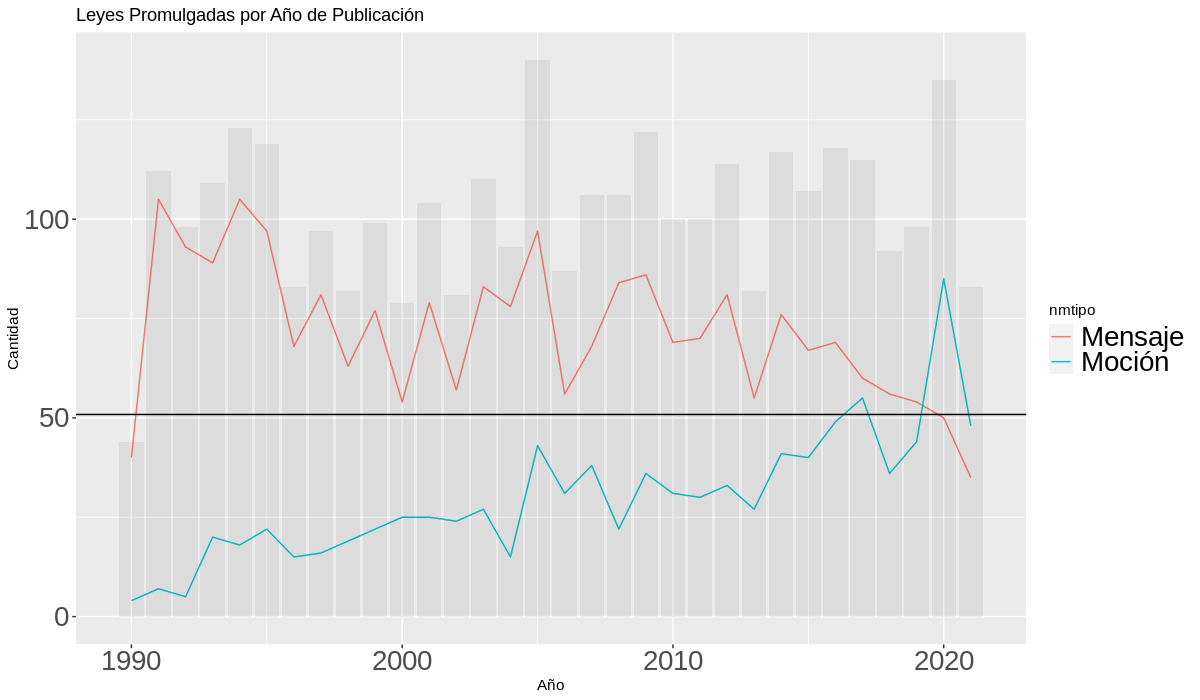

In [32]:
options(repr.plot.width = 12, repr.plot.height = 7, repr.plot.res = 100, warn=-1)
ggplot(tbl_g1, aes(x=anio,y=n)) + 
geom_line(aes(color=nmtipo)) +
theme(strip.text=element_text(size=20),
      axis.text.x= element_text(size=20),
      axis.text.y= element_text(size=20),
      legend.text=element_text(size=20)) +
geom_col(alpha=0.1) +
geom_hline(aes(yintercept=mean(n))) +
labs(title = "Leyes Promulgadas por Año de Publicación", x="Año",y="Cantidad")

Se puede observar que desde 1990 los proyectos de ley promulgados que fueron presentados por el Presidentx (Mensajes) han ido disminuyendo, en especial desde 2016. Por otro lado, ocurre lo contrario  con los proyectos de ley promulgados que fueron presentados por Diputadxs/Senadorxs (Mociones). En el año 2020 la cantidad de leyes promulgadas tipo Moción superó las de tipo Mensaje.

In [33]:
tbl_anio_ingreso <- leyespromulgadas %>% group_by(anio_ingreso, nmtipo) %>% count() 

In [34]:
head(tbl_anio_ingreso)

anio_ingreso,nmtipo,n
<int>,<chr>,<int>
1990,Mensaje,107
1990,Moción,20
1991,Mensaje,139
1991,Moción,26
1992,Mensaje,129
1992,Moción,20


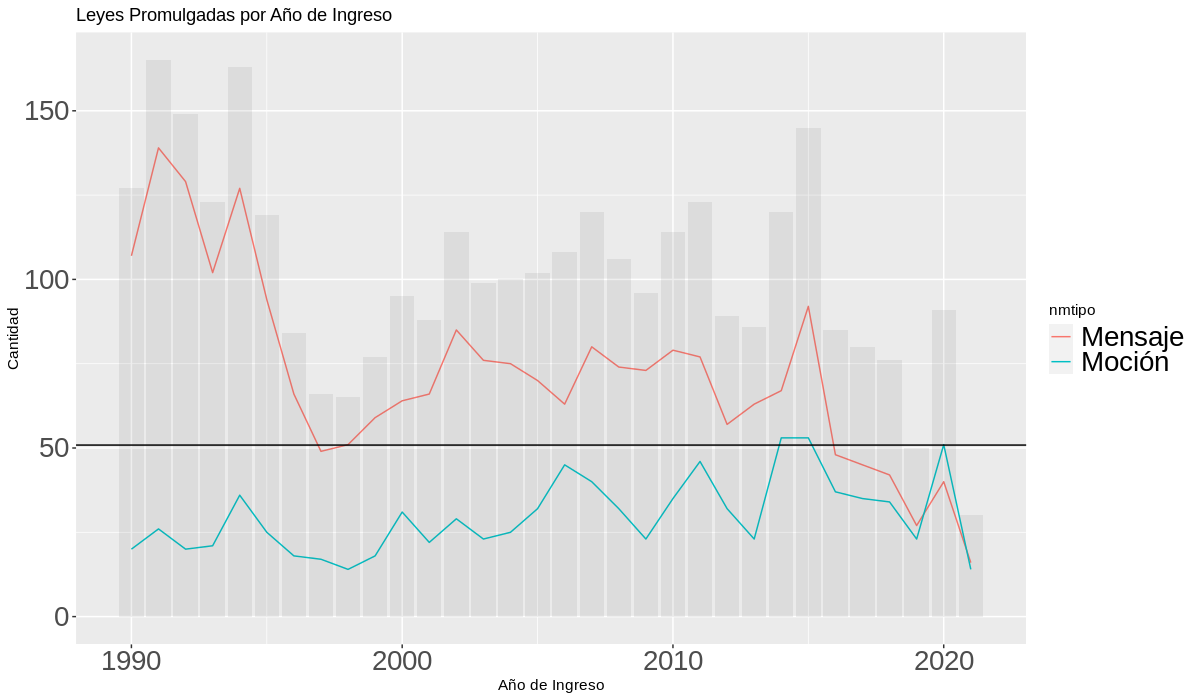

In [35]:
options(repr.plot.width = 12, repr.plot.height = 7, repr.plot.res = 100, warn=-1)
ggplot(tbl_anio_ingreso, aes(x=anio_ingreso,y=n)) + 
geom_line(aes(color=nmtipo)) +
theme(strip.text=element_text(size=20),
      axis.text.x= element_text(size=20),
      axis.text.y= element_text(size=20),
      legend.text=element_text(size=20)) +
geom_col(alpha=0.1) +
geom_hline(aes(yintercept = mean(n))) +
labs(title = "Leyes Promulgadas por Año de Ingreso", x="Año de Ingreso",y="Cantidad")

Al realizar la exploración de leyes promulgadas por año de ingreso, se puede observar dos caídas abruptas de las iniciativas de ley tipo mensaje ocurridas en 1994 y 2015, respectivamente. La segunda caída llevó al punto mínimo de leyes promulgadas tipo Mensaje en todo el período de estudio (23 leyes en 2019). Por otro lado, las iniciativas tipo moción a través de los años presenta una tendencia al alza.

Porcentaje de NAs en bases

In [36]:
print("#### Base Leyes Promulgadas####")
prop.table(table(is.na(leyespromulgadas)))*100
print("#### Base Autores Leyes Promulgadas####")
prop.table(table(is.na(autoresleyespromulgadas)))*100
print("#### Base Materias Leyes Promulgadas####")
prop.table(table(is.na(materiasleyespromulgadas)))*100
print("#### Base Votaciones Leyes Promulgadas####")
prop.table(table(is.na(votacionesleyespromulgadas)))*100
print("#### Base Detalle de Votaciones Leyes Promulgadas####")
prop.table(table(is.na(detallevotosleyespromulgadas)))*100
print("#### Base Periodos Legislativos####")
prop.table(table(is.na(periodos)))*100

[1] "#### Base Leyes Promulgadas####"



FALSE 
  100 

[1] "#### Base Autores Leyes Promulgadas####"



    FALSE      TRUE 
95.507281  4.492719 

[1] "#### Base Materias Leyes Promulgadas####"



     FALSE       TRUE 
99.6600253  0.3399747 

[1] "#### Base Votaciones Leyes Promulgadas####"



    FALSE      TRUE 
97.384212  2.615788 

[1] "#### Base Detalle de Votaciones Leyes Promulgadas####"



     FALSE       TRUE 
99.4821244  0.5178756 

[1] "#### Base Periodos Legislativos####"



    FALSE      TRUE 
98.931624  1.068376 

In [37]:
print("#### Base Diputadxs ####")
prop.table(table(is.na(diputadxs)))*100
print("#### Base Diputadxs agrupadxs por Periodo ####")
prop.table(table(is.na(diputadxstodosperiodos)))*100

[1] "#### Base Diputadxs ####"



    FALSE      TRUE 
96.325322  3.674678 

[1] "#### Base Diputadxs agrupadxs por Periodo ####"



   FALSE     TRUE 
89.96011 10.03989 

In [38]:
print("#### Base Distritos ####")
prop.table(table(is.na(distritos)))*100
print("#### Base Regiones ####")
prop.table(table(is.na(regiones)))*100

[1] "#### Base Distritos ####"



FALSE 
  100 

[1] "#### Base Regiones ####"



FALSE 
  100 

Porcentaje de NAs x columnas en bases

In [39]:
print("#### Base Leyes Promulgadas####")
round((apply(is.na(leyespromulgadas), 2, mean))*100,2)
print("#### Base Autores Leyes Promulgadas####")
round((apply(is.na(autoresleyespromulgadas), 2, mean))*100,2)
print("#### Base Materias Leyes Promulgadas####")
round((apply(is.na(materiasleyespromulgadas), 2, mean))*100,2)
print("#### Base Votaciones Leyes Promulgadas####")
round((apply(is.na(votacionesleyespromulgadas), 2, mean))*100,2)
print("#### Base Detalle de Votaciones Leyes Promulgadas####")
round((apply(is.na(detallevotosleyespromulgadas), 2, mean))*100,2)
print("#### Base Periodos Legislativos####")
round((apply(is.na(periodos), 2, mean))*100,2)

[1] "#### Base Leyes Promulgadas####"


nrproyecto     dtingreso        nmtipo     nmresumen         nrley 
            0             0             0             0             0 
dtpublicacion          anio  anio_ingreso 
            0             0             0

[1] "#### Base Autores Leyes Promulgadas####"


idproyecto      nrboletin nmcamaraorigen        idautor          autor 
          0.00           0.00           0.00          11.23          11.23

[1] "#### Base Materias Leyes Promulgadas####"


idproyecto  nrboletin  idmateria  nmmateria 
      0.00       0.00       0.68       0.68

[1] "#### Base Votaciones Leyes Promulgadas####"


idproyecto        nrboletin       nmproyecto        dtingreso 
            0.00             0.00             0.00             0.00 
  nmtipoproyecto   nmcamaraorigen       idvotacion       dtvotacion 
            0.00             0.00             0.00             0.00 
         totalsi          totalno   totalabtencion totaldispensados 
            0.00             0.00             0.00             0.00 
     nmresultado       nmtiporesu       nmtipovota       nmarticulo 
            9.41             0.00             0.00             0.00 
      nmtramcons       nmtramregl        idautores        nmautores 
            0.00             0.00            23.02            23.02 
      idmaterias       nmmaterias     anio_ingreso  anio_dtvotacion 
            3.66             3.66             0.00             0.00

[1] "#### Base Detalle de Votaciones Leyes Promulgadas####"


idvotacion     descripcion      dtvotacion         totalsi         totalno 
           0.00            0.00            0.00            0.00            0.00 
totalabstencion totaldispensado          quorum       resultado            tipo 
           0.00            0.00            0.00            8.28            0.00 
     iddiputado      nmdiputado     nmapellidop     nmapellidom          nmvoto 
           0.00            0.00            0.00            0.00            0.00 
anio_dtvotacion 
           0.00

[1] "#### Base Periodos Legislativos####"


idperiodo     nmperiodo      dtinicio     dttermino idlegislatura 
         0.00          0.00          0.00          0.00          1.92 
nrlegislatura    dtiniclegi    dttermlegi    nmtipolegi 
         1.92          1.92          1.92          1.92

In [40]:
print("#### Base Diputadxs ####")
round((apply(is.na(diputadxs), 2, mean))*100,2)
print("#### Base Diputadxs agrupadxs por Periodo ####")
round((apply(is.na(diputadxstodosperiodos), 2, mean))*100,2)

[1] "#### Base Diputadxs ####"


iddiputado   nmdiputado    apellidop    apellidom dtnacimiento       nmsexo 
        0.00         0.00         0.00         0.00        18.87         0.00 
    dtinicio    dttermino    idpartido    nmpartido        alias 
        0.00         0.00         7.18         7.18         7.18

[1] "#### Base Diputadxs agrupadxs por Periodo ####"


periodo     dtinicio    dttermino   iddiputado   nmdiputado    apellidop 
        0.00         0.00       100.00         0.00         0.00         0.00 
   apellidom dtnacimiento       nmsexo   nrdistrito    nrcomunas    nmcomunas 
        0.00         7.18         0.00         4.43         4.43         4.43

In [41]:
print("#### Base Distritos ####")
round((apply(is.na(distritos), 2, mean))*100,2)
print("#### Base Regiones ####")
round((apply(is.na(regiones), 2, mean))*100,2)

[1] "#### Base Distritos ####"


iddistrito   nrcomuna   nmcomuna 
         0          0          0

[1] "#### Base Regiones ####"


nrregion      romano    nmregion nrprovincia nmprovincia    nrcomuna 
          0           0           0           0           0           0 
   nmcomuna 
          0

Leyes Sin Autores/Patrocinadores por Año

In [42]:
leyes_anio <- leyespromulgadas %>% 
inner_join(autoresleyespromulgadas,by=c('nrproyecto'='nrboletin')) %>% 
select(nrproyecto, anio) %>%
distinct() %>%
group_by(anio) %>%
count() 

In [43]:
na_autores_anio <- leyespromulgadas %>% 
inner_join(autoresleyespromulgadas,by=c('nrproyecto'='nrboletin')) %>% 
left_join(leyes_anio, by=c('anio'='anio')) %>%
select(nrproyecto, anio, idautor, autor, n) %>%
distinct() %>%
filter(is.na(idautor) | is.na(autor)) %>%
group_by(anio, n) %>%
summarise(cant_na=n()) %>%
ungroup() %>%
arrange(anio) %>%
mutate(porc_na=(cant_na/n)*100)

`summarise()` has grouped output by 'anio'. You can override using the `.groups` argument.



In [44]:
na_autores_anio

anio,n,cant_na,porc_na
<int>,<int>,<int>,<dbl>
1990,44,30,68.181818
1991,112,91,81.250000
1992,98,85,86.734694
1993,109,96,88.073394
1994,123,112,91.056911
1995,119,108,90.756303
1996,83,73,87.951807
1997,97,86,88.659794
1998,82,36,43.902439


In [45]:
leyespromulgadas %>% 
filter(anio %in% seq(2004,2021)) %>%
left_join(autoresleyespromulgadas,by=c('nrproyecto'='nrboletin')) %>% 
left_join(leyes_anio, by=c('anio'='anio')) %>%
filter(anio == 2004) %>%
select(nrproyecto, anio, idautor, autor, n) %>%
filter(is.na(idautor)) %>%
distinct()

nrproyecto,anio,idautor,autor,n
<chr>,<int>,<chr>,<chr>,<int>
3708-07,2004,NA,NA,93
3728-07,2004,NA,NA,93
2802-04,2004,NA,NA,93
3393-17,2004,NA,NA,93
2853-04,2004,NA,NA,93
3637-07,2004,NA,NA,93
2851-07,2004,NA,NA,93
3389-07,2004,NA,NA,93
3387-10,2004,NA,NA,93


Leyes Sin Materias por Año

In [46]:
leyes_anio_2 <- leyespromulgadas %>% 
inner_join(materiasleyespromulgadas,by=c('nrproyecto'='nrboletin')) %>% 
select(nrproyecto, anio) %>%
distinct() %>%
group_by(anio) %>%
count() 

In [47]:
na_materias_anio <- leyespromulgadas %>% 
inner_join(materiasleyespromulgadas,by=c('nrproyecto'='nrboletin')) %>% 
left_join(leyes_anio_2, by=c('anio'='anio')) %>%
select(nrproyecto, anio, idmateria, nmmateria, n) %>%
distinct() %>%
filter(is.na(idmateria) | is.na(nmmateria)) %>%
group_by(anio, n) %>%
summarise(cant_na=n()) %>%
ungroup() %>%
arrange(anio) %>%
mutate(porc_na=(cant_na/n)*100)

`summarise()` has grouped output by 'anio'. You can override using the `.groups` argument.



In [48]:
na_materias_anio

anio,n,cant_na,porc_na
<int>,<int>,<int>,<dbl>
1993,109,2,1.8348624
1994,123,2,1.6260163
1998,82,1,1.2195122
1999,99,1,1.0101010
2001,104,1,0.9615385
2004,93,3,3.2258065
2005,140,3,2.1428571
2006,87,1,1.1494253
2007,106,3,2.8301887


#### 3. Análisis

##### 3.1 Temáticas de Leyes Promulgadas
Análisis Automatizado de Texto - Usando el campo resumen de las leyes.

In [49]:
# Extrae las palabras del resumen de cada ley promulgada
proyectos <- leyespromulgadas %>% 
select(nrproyecto, nmresumen, anio) %>% 
mutate(proy_id = row_number()) %>%
unnest_tokens(word, nmresumen) %>%
filter(!word %in% stopwords::stopwords("es", "stopwords-iso"))

In [50]:
# Crea tabla tf-idf
proyectos_tf_idf <- proyectos %>%
count(anio, word, sort = TRUE) %>%
bind_tf_idf(word, anio, n) %>%
arrange(-tf_idf) %>%
group_by(anio) %>%
top_n(7) %>%
ungroup

Selecting by tf_idf



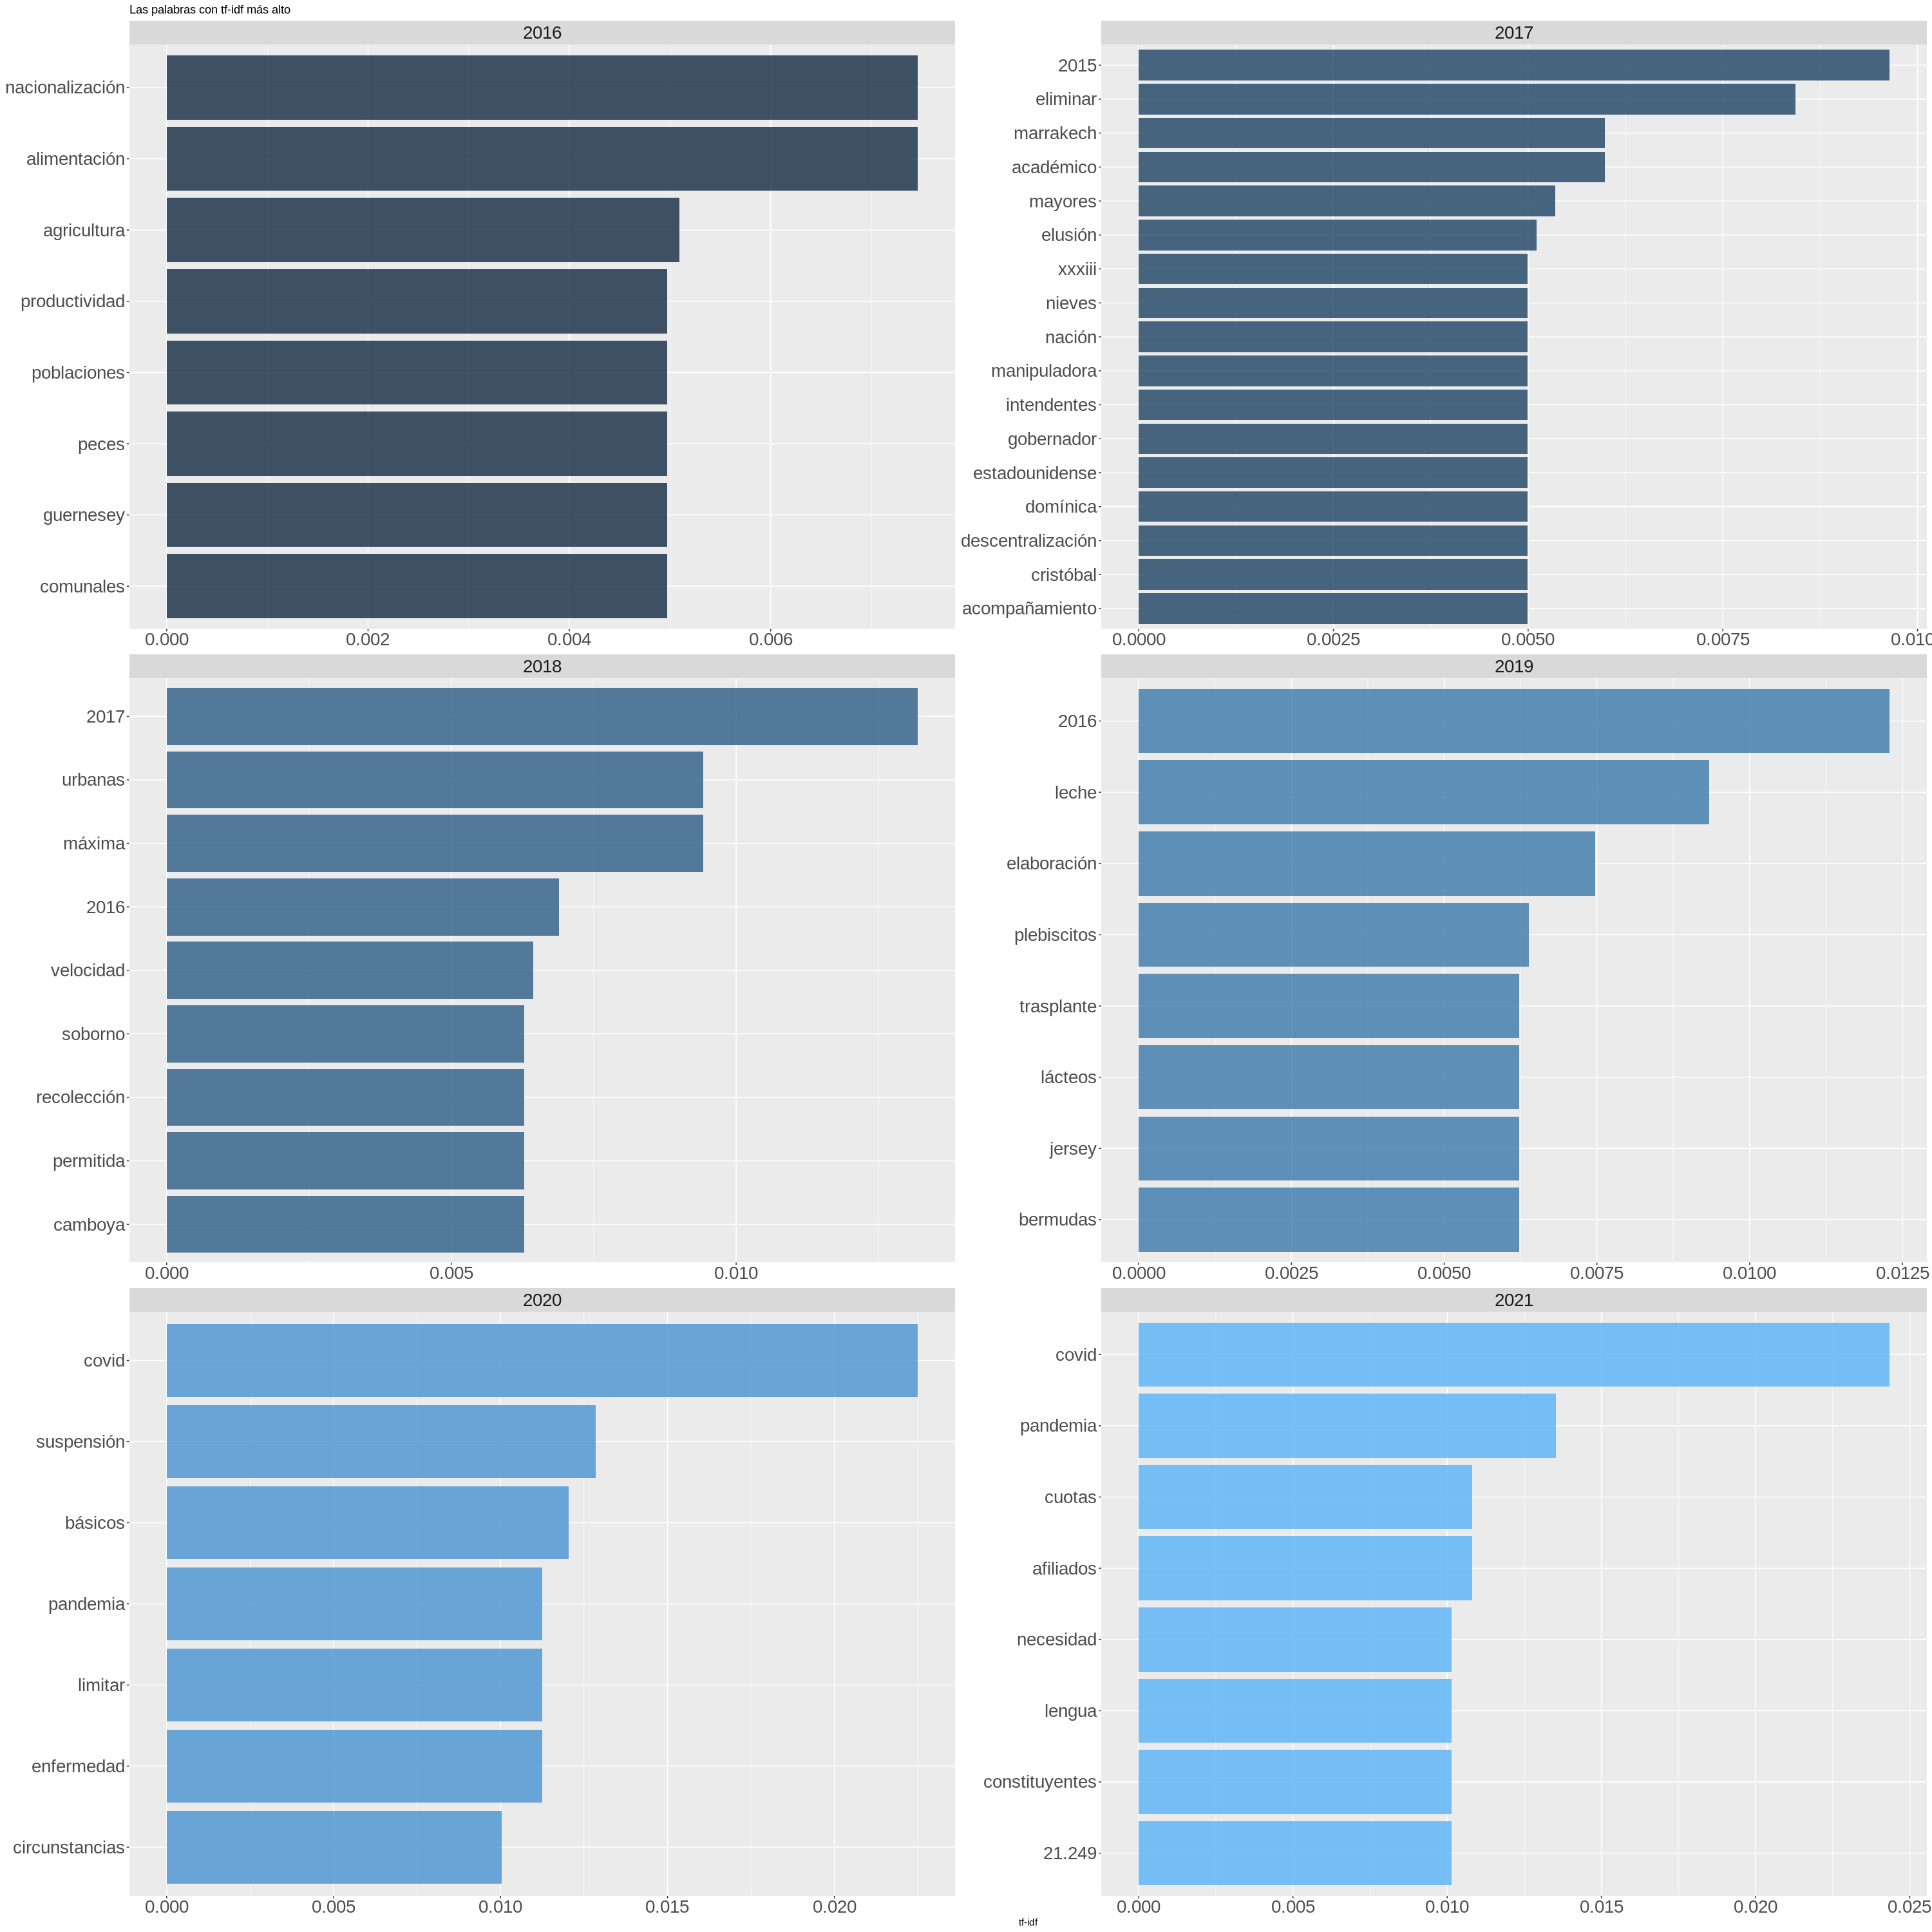

In [51]:
# Crea gráfico de barras de términos mas frecuentes en el resumen de ley por año
# de publicación
options(repr.plot.width = 30, repr.plot.height = 30, repr.plot.res = 100, warn=-1)
proyectos_tf_idf %>% 
filter(anio %in% seq(2016, 2021)) %>%
mutate(word = reorder_within(as.factor(word), tf_idf, anio)) %>%
ggplot(aes(word, tf_idf, fill=anio)) +
geom_col(alpha = 0.8, show.legend = FALSE) +
facet_wrap(vars(anio), scales = "free", ncol = 2) +
scale_x_reordered() +
coord_flip() +
theme(strip.text=element_text(size=20),
      axis.text.x= element_text(size=20),
      axis.text.y= element_text(size=20)) +
  labs(x = NULL, y = "tf-idf",
       title = "Las palabras con tf-idf más alto")

En los años 2020 y 2021 predomina el contexto de la Pandemia Covid-19 y todas las iniciativas en ayuda a los ciudadanos como la suspensión de pago de servicios básicos, modificaciones de decretos del Ministerio de Salud, postergación de cuotas, entre otras.
La palabra lengüa viene del conexto lengüa de señas para promover la inclusión social.

En algunos años, se repite en varias ocaciones un año especifico. Esto se debe a que en el resumen de la ley citan la fecha en que fue suscrito el acuerdo que el congreso debe ratificar. Observando los datos, se encontraron varios casos en los cuales pasaron 2 o 3 años entre la firma del acuerdo y la promulgación de la ley. 

In [52]:
leyespromulgadas %>% filter(anio==2017,grepl('2015',nmresumen))
leyespromulgadas %>% filter(anio==2018,grepl('2016',nmresumen))
leyespromulgadas %>% filter(anio==2019,grepl('2016',nmresumen))

nrproyecto,dtingreso,nmtipo,nmresumen,nrley,dtpublicacion,anio,anio_ingreso
<chr>,<date>,<chr>,<chr>,<chr>,<date>,<int>,<int>
10777-10,2016-06-23,Mensaje,"Aprueba la Convención Interamericana sobre la Protección de los Derechos Humanos de las Personas Mayores, adoptada el 15 de junio de 2015 por la Asamblea General de la Organización de los Estados Americanos, durante su XLV Periodo Ordinario de Sesiones, celebrada en Washington, D.C., Estados Unidos de América",D.S N° 162,2017-10-07,2017,2016
10684-10,2016-05-16,Mensaje,"Aprueba el Acuerdo entre el Gobierno de la República de Chile y el Gobierno de la República de Corea sobre Cooperación en los Ámbitos de la Industria de Defensa y el Apoyo Logístico, suscrito en Santiago, Chile, el 22 de abril de 2015",D.S N° 63,2017-07-10,2017,2016
10939-10,2016-10-25,Mensaje,"Aprueba el Acuerdo de París, adoptado en la Vigésimo Primera Reunión de la Conferencia de las Partes de la Convención Marco de las Naciones Unidas sobre el Cambio Climático, en París, el 12 de diciembre de 2015",D.S N° 30,2017-05-23,2017,2016
10934-10,2016-10-20,Mensaje,"Aprueba el Convenio entre la República de Chile y la República Checa para Eliminar la Doble Imposición y para Prevenir la Evasión Fiscal en Relación a los Impuestos sobre la Renta y al Patrimonio, suscrito en Santiago, Chile, el 2 de diciembre de 2015",D.S N° 206,2017-04-29,2017,2016
10933-10,2016-10-20,Mensaje,"Aprueba el Convenio entre el Gobierno de la República de Chile y el Gobierno de la República Italiana para Eliminar la Doble Imposición con Relación a los Impuestos sobre la Renta y para Prevenir la Evasión y Elusión Fiscal, y su Protocolo, suscritos en Santiago, República de Chile, el 23 de octubre de 2015",D.S N° 205,2017-04-12,2017,2016
10713-10,2016-05-26,Mensaje,"Aprueba el Convenio de Reconocimiento Mutuo de Títulos Profesionales y Grados Académicos de Educación Superior entre la República de Chile y la República de Ecuador, suscrito en Quito, República de Ecuador, el 15 de octubre de 2015",D.S N° 7,2017-04-07,2017,2016
10481-10,2015-12-30,Mensaje,"Aprueba el Convenio de Seguridad Social entre el Gobierno de la República de Chile y el Gobierno de la República de Corea, suscrito en Santiago el 22 de abril de 2015",Decreto N° 184,2017-02-14,2017,2015
10345-10,2015-10-19,Mensaje,"Aprueba el Convenio entre el Gobierno de la República de Chile y el Gobierno de la República Popular China para Eliminar la Doble Imposición y para Prevenir la Evasión y Elusión Fiscal en relación a los Impuestos sobre la Renta y su Protocolo, suscritos en Santiago, el 25 de mayo de 2015",Decreto N° 129,2017-01-09,2017,2015


nrproyecto,dtingreso,nmtipo,nmresumen,nrley,dtpublicacion,anio,anio_ingreso
<chr>,<date>,<chr>,<chr>,<chr>,<date>,<int>,<int>
11348-10,2017-08-01,Mensaje,"Aprueba el Acuerdo entre el Gobierno de la República de Chile y el Gobierno de la República de Sudáfrica sobre Exención del Requisito de Visa para los Titulares de Pasaportes Diplomáticos u Oficiales, suscrito en Pretoria, el 1 de septiembre de 2016",D.S N° 115,2018-12-29,2018,2017
11345-10,2017-08-01,Mensaje,"Aprueba el Acuerdo entre el Gobierno de la República de Chile y el Gobierno de la República de Belarús sobre Exención de Visas para Titulares de Pasaportes Diplomáticos, de Servicio y Oficiales, suscrito en Santiago, Chile, el 21 de noviembre de 2016",D.S N° 264,2018-12-29,2018,2017
11347-10,2017-08-01,Mensaje,"Aprueba el Acuerdo entre el Gobierno de la República de Chile y el Gobierno del Reino de Marruecos sobre Exención del Requisito de Visa para Titulares de Pasaportes Diplomáticos, Oficiales, Especiales y de Servicio, suscrito en Nueva York, el 20 de septiembre de 2016",D.S N° 257,2018-12-29,2018,2017
10963-10,2016-11-10,Mensaje,"Acuerdo de Reconocimiento Mutuo de Títulos y Grados entre la República de Chile y el Reino Unido de Gran Bretaña e Irlanda del Norte, suscrito en Londres, el 13 de mayo de 2016",D.S N° 15,2018-04-05,2018,2016
11048-10,2016-12-21,Mensaje,"Aprueba el Tratado que Modifica el Acuerdo de Sede entre el Gobierno de la República de Chile y la Organización de Estados Iberoamericanos para la Educación, la Ciencia y la Cultura, suscrito en Andorra, el 12 de septiembre de 2016",Decreto N° 248,2018-01-25,2018,2016


nrproyecto,dtingreso,nmtipo,nmresumen,nrley,dtpublicacion,anio,anio_ingreso
<chr>,<date>,<chr>,<chr>,<chr>,<date>,<int>,<int>
11611-10,2018-03-05,Mensaje,"Aprueba el Acuerdo de Inversiones entre el Gobierno de la República de Chile y el Gobierno de la Región Administrativa Especial de Hong Kong de la República Popular China y sus Anexos, suscrito en Lima, Perú, el 18 de noviembre de 2016",D.S N° 78,2019-10-08,2019,2018
11609-10,2018-03-05,Mensaje,"Aprueba el Acuerdo de Intercambio de Información en Materia Tributaria entre la República de Chile y Jersey, suscrito en Santiago, Chile, el 24 de junio de 2016, y en Saint Helier, Jersey, el 21 de julio de 2016",D.S N° 306,2019-05-22,2019,2018
11610-10,2018-03-05,Mensaje,"Aprueba el Acuerdo sobre Intercambio de Información en Materia Tributaria entre la República de Chile y Bermudas, suscrito en Santiago, Chile, el 24 de junio de 2016, y en Hamilton, Bermudas, el 21 de julio 2016",D.S N° 357,2019-05-22,2019,2018
11334-10,2017-07-21,Mensaje,"Aprueba el Acuerdo de Libre Comercio entre la República de Chile y la República Oriental del Uruguay, suscrito en Montevideo, Uruguay, el 4 de octubre de 2016",D.S N° 318,2019-04-03,2019,2017
11344-10,2017-08-01,Mensaje,"Aprueba el Acuerdo entre el Gobierno de la República de Chile y el Gobierno de la República de la India relativo a la autorización para realizar actividades remuneradas a familiares dependientes del personal diplomático, consular, técnico y administrativo asignado a misiones diplomáticas y consulares, suscrito en Nueva Delhi, el 28 de octubre de 2016",D.S N° 334,2019-04-03,2019,2017
11167-10,2017-03-24,Mensaje,"Aprueba el Convenio de Transporte Aéreo entre el Gobierno de la República de Chile y el Gobierno de la República Cooperativa de Guyana, suscrito en Santiago, Chile, el 24 de octubre de 2016",D.S N° 89,2019-04-03,2019,2017
11528-10,2017-12-05,Mensaje,"Aprueba el Convenio entre el Gobierno de la República de Chile y el Gobierno de la República Oriental del Uruguay para Eliminar la Doble Imposición con Relación a los Impuestos sobre la Renta y sobre el Patrimonio y para Prevenir la Evasión y Elusión Fiscal y su Protocolo, suscritos en Montevideo, República Oriental del Uruguay, el 1 de abril de 2016",D.S N° 271,2019-01-24,2019,2017


##### 3.2 Temáticas de Leyes Promulgadas
Análisis Automatizado de Texto - Usando las temáticas asociadas al proyecto de ley en su definición.

In [53]:
# Número de registros en data.frame
nrow(materiasleyespromulgadas)
# Número de leyes promulgadas
length(unique(materiasleyespromulgadas$nrboletin))
# Nombre de columnas
colnames(materiasleyespromulgadas)
# Nombre de columnas tabla leyes promulgadas
colnames(leyespromulgadas)

[1] 6324

[1] 3255

[1] "idproyecto" "nrboletin"  "idmateria"  "nmmateria"

[1] "nrproyecto"    "dtingreso"     "nmtipo"        "nmresumen"    
[5] "nrley"         "dtpublicacion" "anio"          "anio_ingreso"

In [54]:
proyectos2 <- left_join(materiasleyespromulgadas, leyespromulgadas, by=c('nrboletin'='nrproyecto')) %>%
select(nrboletin, dtpublicacion, anio, idmateria, nmmateria) 

In [55]:
head(proyectos2)

,nrboletin,dtpublicacion,anio,idmateria,nmmateria
,<chr>,<date>,<int>,<chr>,<chr>
1,12826-13,2021-07-27,2021,22382,DOCUMENTOS ELECTRONICOS LABORALES
2,14225-13,2021-07-12,2021,23026,CORONAVIRUS
3,14225-13,2021-07-12,2021,23027,COVID-19
4,14225-13,2021-07-12,2021,23083,CORONAVIRUS COVID-19
5,12598-21,2021-07-12,2021,4976,PESCA RECREATIVA
6,12598-21,2021-07-12,2021,5441,SANCIONES


In [56]:
proy2 <- proyectos2  %>% 
select(nrboletin, nmmateria, anio) %>% 
mutate(proy_id = row_number()) %>%
unnest_tokens(word, nmmateria) %>%
filter(!word %in% stopwords::stopwords("es", "stopwords-iso"))

In [57]:
head(proy2)

,nrboletin,anio,proy_id,word
,<chr>,<int>,<int>,<chr>
1,12826-13,2021,1,documentos
2,12826-13,2021,1,electronicos
3,12826-13,2021,1,laborales
4,14225-13,2021,2,coronavirus
5,14225-13,2021,3,covid
6,14225-13,2021,3,19


In [58]:
proyectos2_tf_idf <- proy2 %>%
count(anio, word, sort = TRUE) %>%
bind_tf_idf(word, anio, n) %>%
arrange(-tf_idf) %>%
group_by(anio) %>%
top_n(7) %>%
ungroup

Selecting by tf_idf



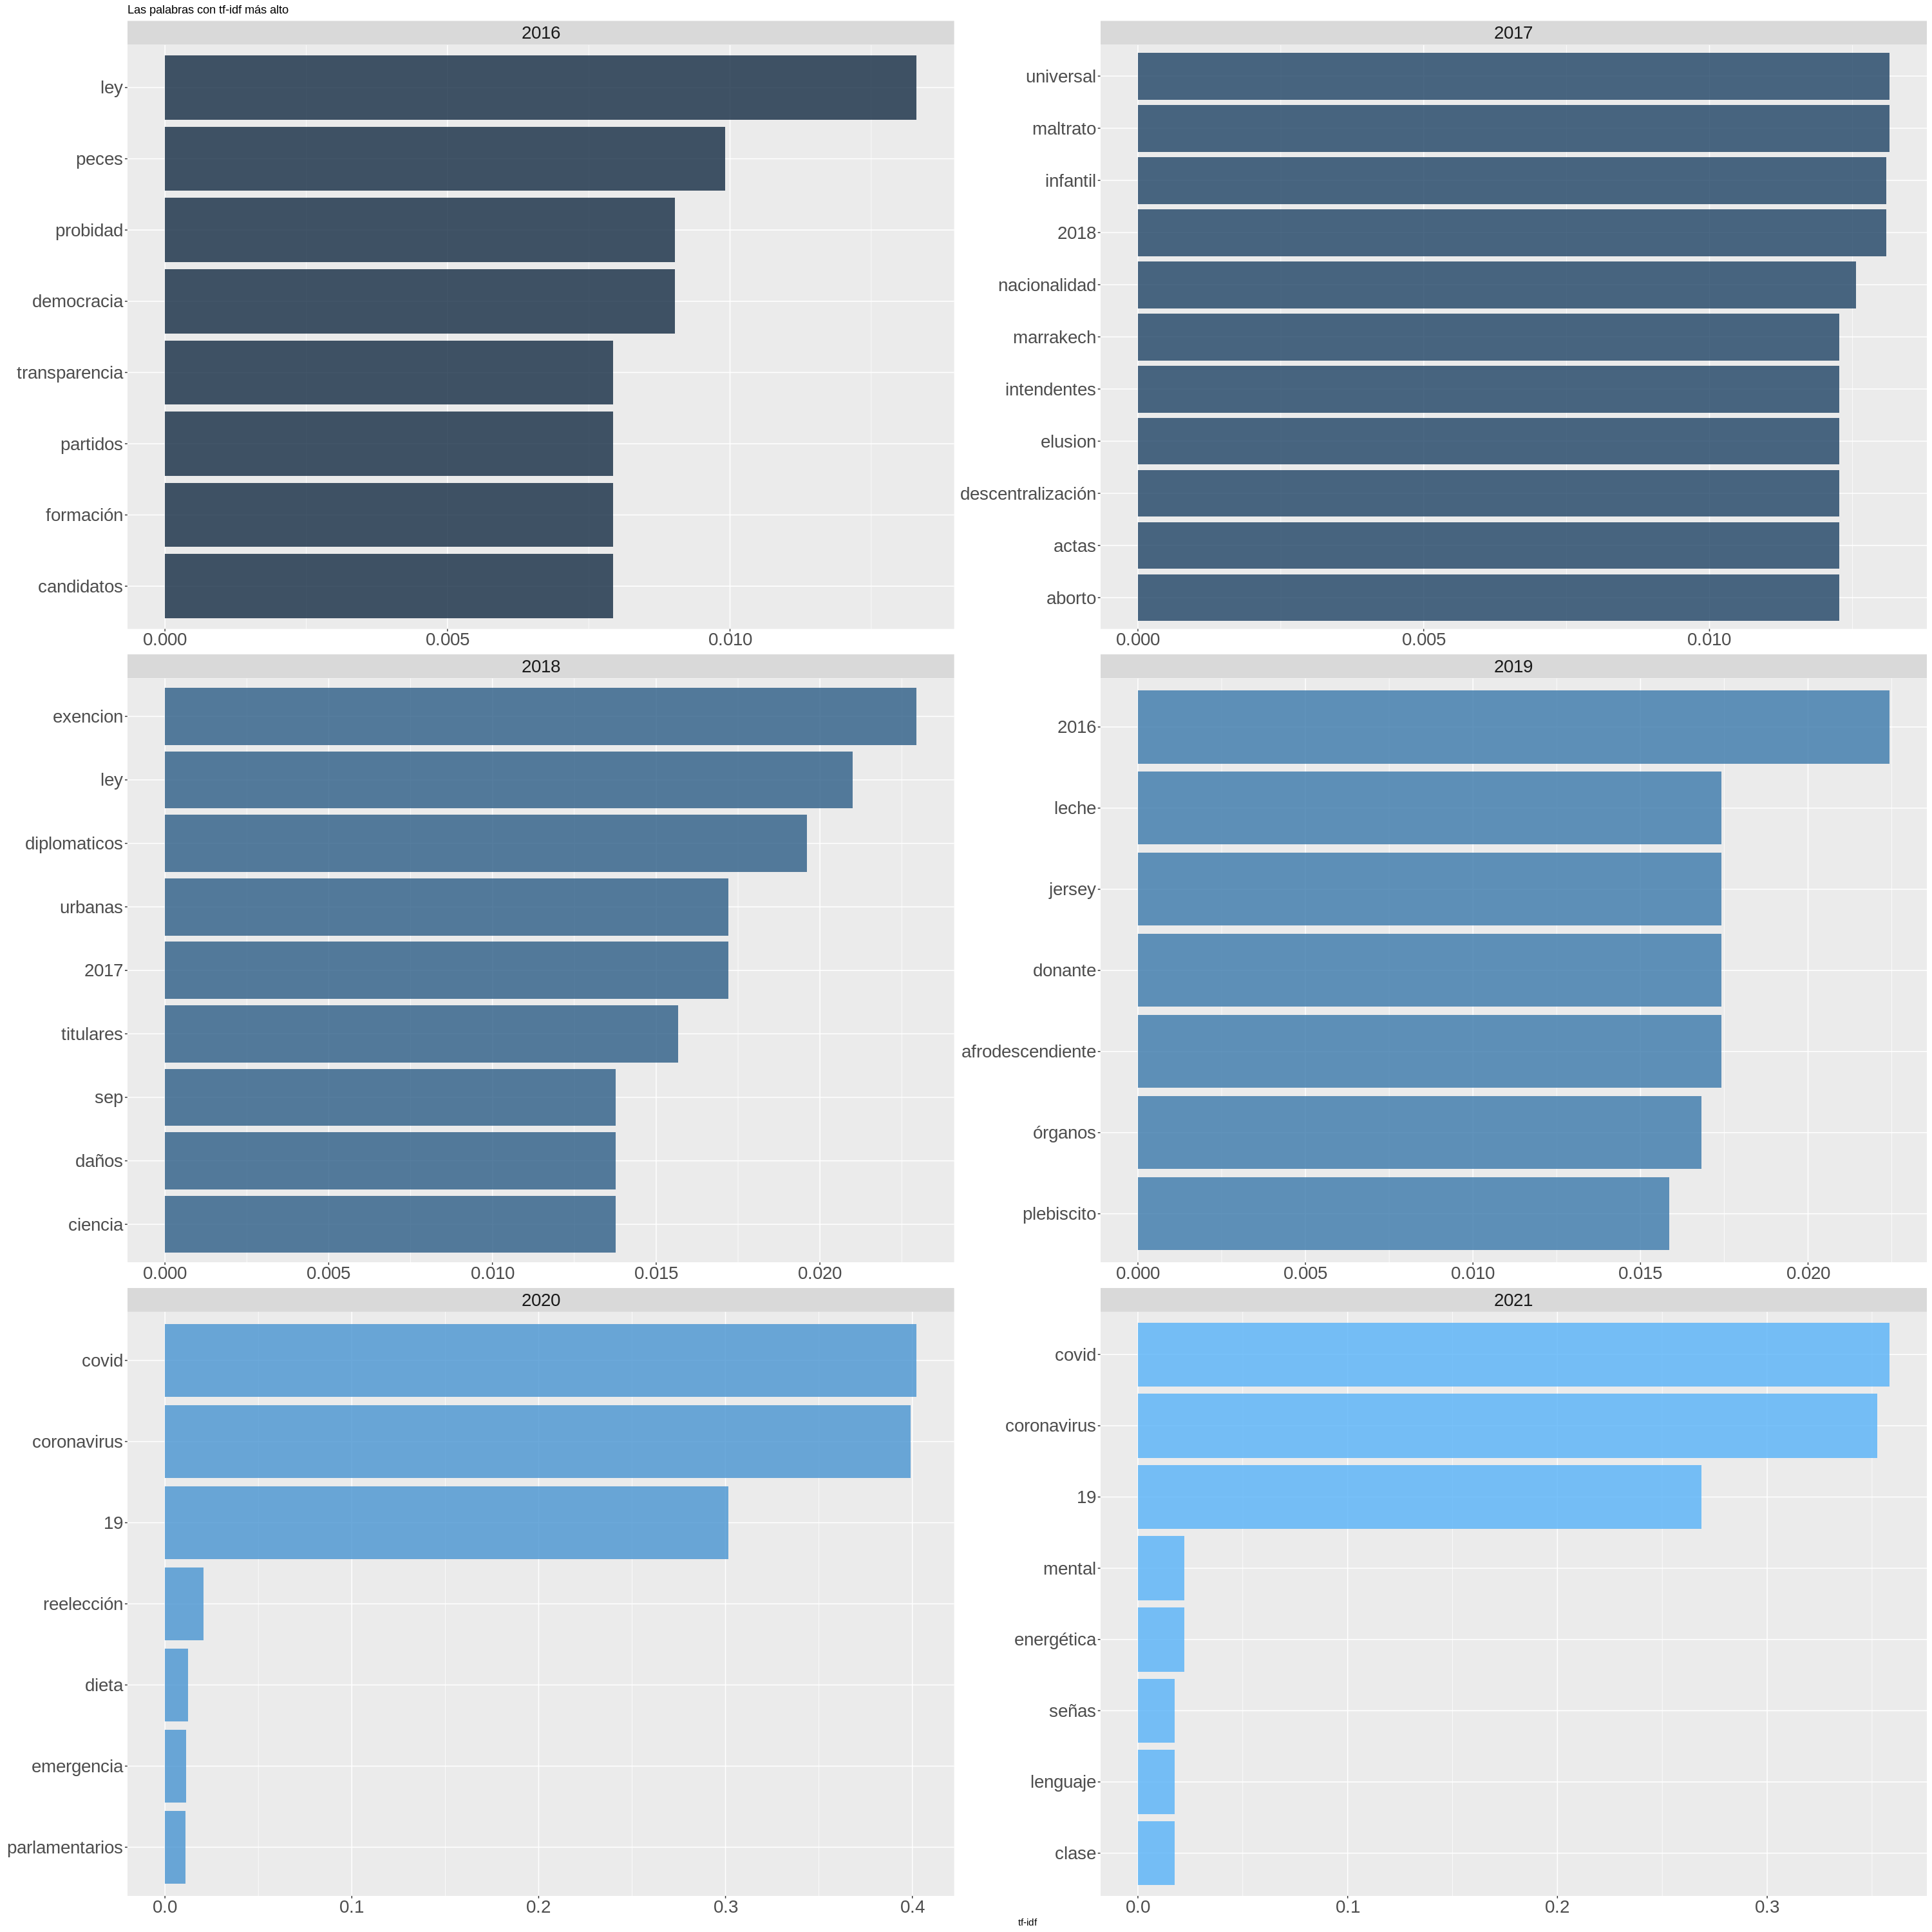

In [59]:
options(repr.plot.width = 30, repr.plot.height = 30, repr.plot.res = 100, warn=-1)
proyectos2_tf_idf %>% 
filter(anio %in% seq(2016, 2021)) %>%
mutate(word = reorder_within(as.factor(word), tf_idf, anio)) %>%
ggplot(aes(word, tf_idf, fill=anio)) +
geom_col(alpha = 0.8, show.legend = FALSE) +
facet_wrap(vars(anio), scales = "free", ncol = 2) +
scale_x_reordered() +
coord_flip() +
theme(strip.text=element_text(size=20),
      axis.text.x= element_text(size=20),
      axis.text.y= element_text(size=20)) +
  labs(x = NULL, y = "tf-idf",
       title = "Las palabras con tf-idf más alto")

Al aplicar topic modelling a las temáticas de las leyes promulgadas se confirman los tópicos encontrados en el ejercicio anterior. En especial, los años 2020 y 2021 se encuentran marcados por el contexto de la pandemia covid-19.

##### 3.3 Proyectos por Distrito Electoral
Análisis de Datos Geográficos

In [60]:
nrow(leyespromulgadas)
nrow(autoresleyespromulgadas)
autoresleyespromulgadas %>% select(nrboletin) %>% distinct() %>% nrow() # OK

colnames(leyespromulgadas)
colnames(autoresleyespromulgadas)

[1] 3255

[1] 8378

[1] 3255

[1] "nrproyecto"    "dtingreso"     "nmtipo"        "nmresumen"    
[5] "nrley"         "dtpublicacion" "anio"          "anio_ingreso"

[1] "idproyecto"     "nrboletin"      "nmcamaraorigen" "idautor"       
[5] "autor"

In [61]:
# Cruza la base de leyes promulgadas con la base de autores x leyes promulgadas
# y calcula el número de leyes por año y autor.
leyes_autores <- inner_join(leyespromulgadas, autoresleyespromulgadas, by=c('nrproyecto'='nrboletin')) %>%
select(nrproyecto, dtingreso, anio_ingreso, idautor, autor, nmtipo,nmcamaraorigen) %>% 
group_by(anio_ingreso, idautor, autor) %>%
distinct() %>%
mutate(n=n()) %>%
arrange(anio_ingreso, -n) %>% 
ungroup()

In [62]:
nrow(leyes_autores)
length(unique(leyes_autores$nrproyecto)) # OK
length(unique(leyes_autores$idautor))
length(unique(leyes_autores$autor))

[1] 8378

[1] 3255

[1] 502

[1] 518

In [63]:
# Búsqueda de id de autores diputados
leyes_autores %>% 
filter(nmtipo != 'Mensaje') %>%
filter(nmcamaraorigen != 'Senado') %>%
select(idautor, autor) %>% 
distinct() %>% 
group_by(idautor) %>% 
count() %>% 
ungroup() %>% 
arrange(-n) %>%
filter(n>1) %>%
nrow()

[1] 0

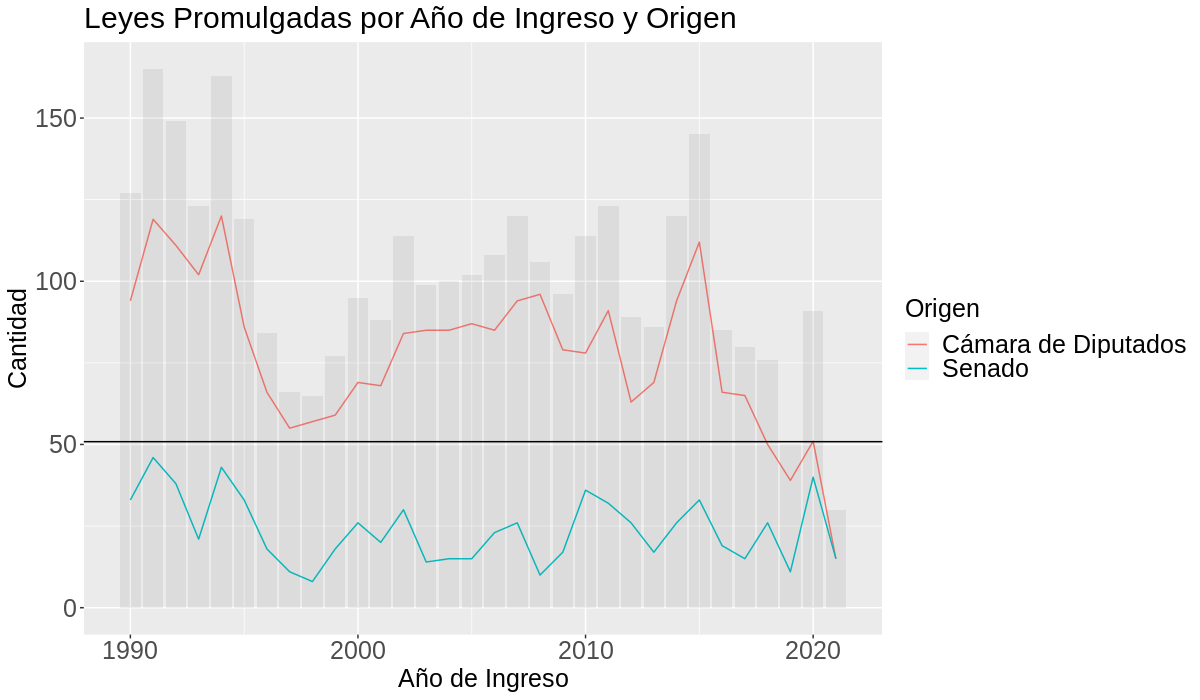

In [64]:
# Leyes promulgadas por año de ingreso y cámara de origen
tbl_leyes_origen <- leyes_autores %>% 
select(nrproyecto, anio_ingreso, nmcamaraorigen) %>%
distinct() %>%
group_by(anio_ingreso, nmcamaraorigen) %>% 
distinct() %>% 
count() 
options(repr.plot.width = 12, repr.plot.height = 7, repr.plot.res = 100, warn=-1)
ggplot(tbl_leyes_origen, aes(x=anio_ingreso,y=n)) + 
geom_line(aes(color=nmcamaraorigen)) +
geom_col(alpha=0.1) +
geom_hline(aes(yintercept = mean(n))) +
scale_color_discrete(name="Origen") +
theme(strip.text=element_text(size=18),
      axis.text.x= element_text(size=18),
      axis.text.y= element_text(size=18),
      legend.title = element_text(size=18),
      legend.text=element_text(size=18),
      title=element_text(size=18)) +
labs(title = "Leyes Promulgadas por Año de Ingreso y Origen", x="Año de Ingreso",y="Cantidad") 

In [65]:
# Total leyes promulgadas son 3255 (OK)
leyes_autores %>% 
select(nrproyecto, nmcamaraorigen, nmtipo) %>% 
distinct() %>% 
group_by(nmcamaraorigen, nmtipo) %>% 
count()

nmcamaraorigen,nmtipo,n
<chr>,<chr>,<int>
Cámara de Diputados,Mensaje,1895
Cámara de Diputados,Moción,599
Senado,Mensaje,407
Senado,Moción,354


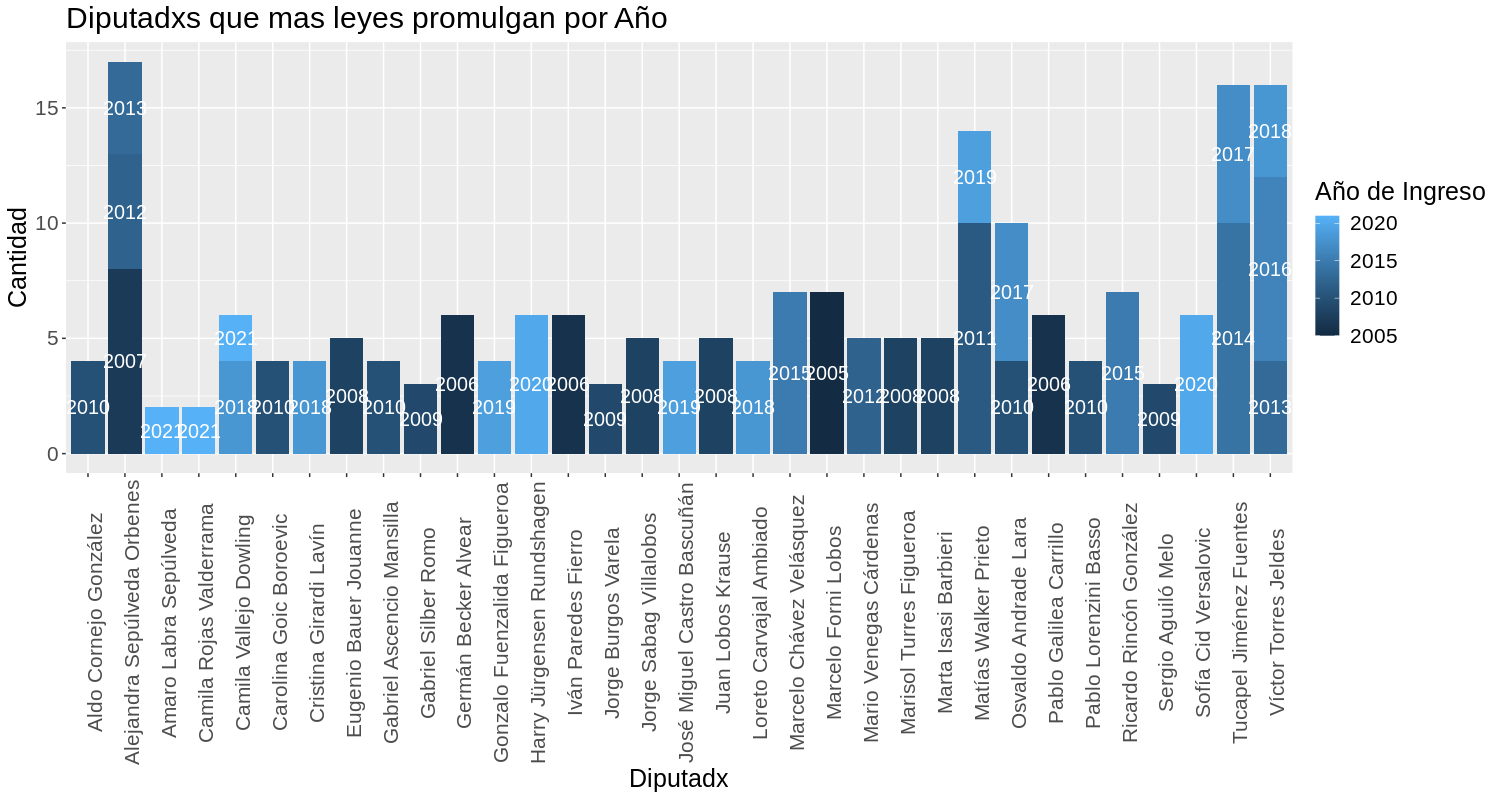

In [66]:
# Diputadxs con mas leyes promulgadas por año(s)
options(repr.plot.width = 15, repr.plot.height = 8, repr.plot.res = 100, warn=-1)
leyes_autores %>%
filter(nmcamaraorigen != 'Senado') %>%
filter(!is.na(idautor)) %>%
filter(nmtipo %in% c('Moción','Mocion')) %>%
filter(anio_ingreso %in% seq(2005,2021)) %>% 
select(nrproyecto, anio_ingreso, idautor, autor, nmtipo, n) %>%
distinct() %>%
arrange(-n) %>%
select(anio_ingreso, idautor, autor, n) %>%
distinct() %>%
group_by(anio_ingreso) %>%
top_n(1,n) %>%
ungroup() %>%
arrange(anio_ingreso) %>%
ggplot() +
geom_col(aes(x=as.factor(autor),y=n,fill=anio_ingreso)) +
geom_text(aes(x=as.factor(autor),y=n,label=anio_ingreso),color="white",position = position_stack(vjust = 0.5),size=5) +
theme(strip.text=element_text(size=15),
      axis.text.x= element_text(size=15,angle=90),
      axis.text.y= element_text(size=15),
      legend.text=element_text(size=15),
      title=element_text(size=18)) +
scale_fill_continuous(name="Año de Ingreso") +
labs(title = "Diputadxs que mas leyes promulgan por Año", x="Diputadx",y="Cantidad") 


In [67]:
# Diputadxs con mas leyes promulgadas desde 2005
leyes_autores %>%
filter(nmcamaraorigen != 'Senado') %>%
filter(!is.na(idautor)) %>%
filter(nmtipo %in% c('Moción','Mocion')) %>%
filter(anio_ingreso %in% seq(2005,2021)) %>% 
select(nrproyecto, idautor, autor) %>%
distinct() %>%
group_by(idautor, autor) %>% 
count() %>%
ungroup() %>%
top_n(1,n) %>%
arrange(-n) 


idautor,autor,n
<chr>,<chr>,<int>
897,Alejandra Sepúlveda Orbenes,59


A partir de los resultados podemos inferir que 33 diputa@s han sido los autores que mas leyes promulgadas han ingresado desde 2005 a 2020. Es importante mencionar que desde que ingresa una ley pueden transcurrir varios años para que sea promulgada, a excepción de urgencias. Por otro lado, la diputada Alejandra Sepúlveda Orbenes es quién a lo largo del período (y desde que hay registros) ha logrado impulsar la mayor cantidad de leyes promulgadas, no obstante, es necesario considerar que dicha diputada pertenece a la Cámara desde 2002 a la fecha.

In [68]:
# Diputadxs con mas leyes promulgadas en un año
leyes_autores %>%
filter(nmcamaraorigen != 'Senado') %>%
filter(!is.na(idautor)) %>%
filter(nmtipo %in% c('Moción','Mocion')) %>%
filter(anio_ingreso %in% seq(2005,2021)) %>% 
select(nrproyecto, anio_ingreso, idautor, autor, nmtipo, n) %>%
distinct() %>%
arrange(-n) %>%
select(anio_ingreso, idautor, autor, n) %>%
distinct() %>%
top_n(1,n) %>%
arrange(anio_ingreso)

anio_ingreso,idautor,autor,n
<int>,<chr>,<chr>,<int>
2011,963,Matías Walker Prieto,10
2014,856,Tucapel Jiménez Fuentes,10


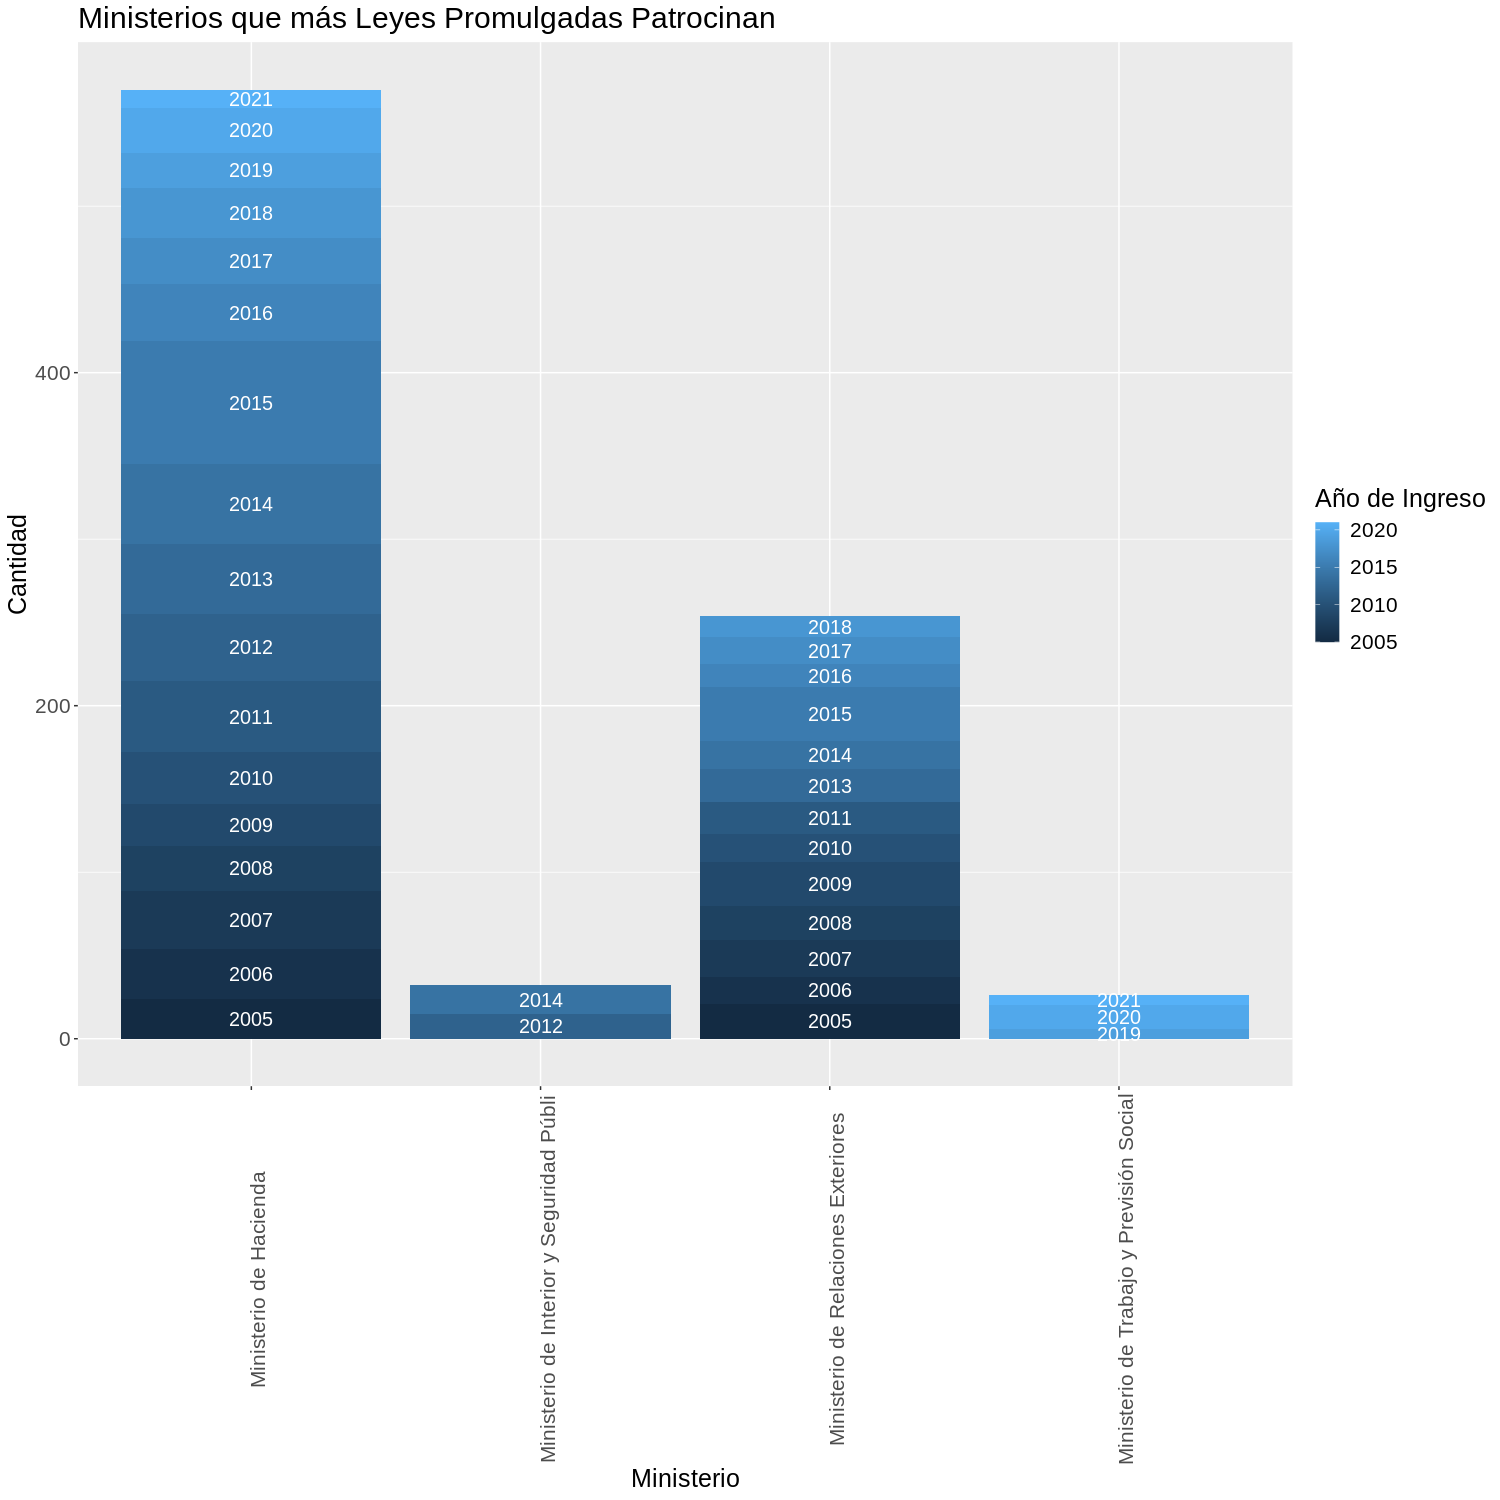

In [69]:
# Ministerios en top 2 de leyes promulgadas patrocinadas por los primeros
options(repr.plot.width = 15, repr.plot.height = 15, repr.plot.res = 100, warn=-1)
leyes_autores %>%
filter(nmcamaraorigen != 'Senado') %>%
filter(!is.na(idautor)) %>%
filter(nmtipo %in% c('Mensaje')) %>%
filter(anio_ingreso %in% seq(2005,2021)) %>% 
select(nrproyecto, anio_ingreso, idautor, autor, nmtipo, n) %>%
distinct() %>%
arrange(-n) %>%
select(anio_ingreso, idautor, autor, n) %>%
distinct() %>%
group_by(anio_ingreso) %>%
top_n(2,n) %>%
ungroup() %>%
arrange(anio_ingreso) %>%
ggplot() +
geom_col(aes(x=as.factor(autor),y=n,fill=anio_ingreso)) +
geom_text(aes(x=as.factor(autor),y=n,label=anio_ingreso),color="white",position = position_stack(vjust = 0.5),size=5) +
theme(strip.text=element_text(size=10),
      axis.text.x= element_text(size=15,angle=90),
      axis.text.y= element_text(size=15),
      legend.text=element_text(size=15),
      legend.title = element_text(size=18),
      title=element_text(size=18)) +
scale_fill_continuous(name="Año de Ingreso") +
labs(title = "Ministerios que más Leyes Promulgadas Patrocinan", x="Ministerio",y="Cantidad") 

In [70]:
leyes_autores %>%
filter(nmcamaraorigen != 'Senado') %>%
filter(!is.na(idautor)) %>%
filter(nmtipo %in% c('Mensaje')) %>%
filter(anio_ingreso %in% seq(2005,2021)) %>% 
select(nrproyecto, anio_ingreso, idautor, autor, nmtipo, n) %>%
distinct() %>%
arrange(-n) %>%
select(anio_ingreso, idautor, autor, n) %>%
distinct() %>%
group_by(anio_ingreso) %>%
top_n(2,n) %>%
ungroup() %>%
arrange(anio_ingreso)

anio_ingreso,idautor,autor,n
<int>,<chr>,<chr>,<int>
2005,2,Ministerio de Hacienda,24
2005,51,Ministerio de Relaciones Exteriores,21
2006,2,Ministerio de Hacienda,30
2006,51,Ministerio de Relaciones Exteriores,16
2007,2,Ministerio de Hacienda,35
2007,51,Ministerio de Relaciones Exteriores,22
2008,2,Ministerio de Hacienda,27
2008,51,Ministerio de Relaciones Exteriores,21
2009,51,Ministerio de Relaciones Exteriores,26


Históricamente el Ministerio de Hacienda y Ministerio de Relaciones son los que mas han patrocinado leyes promulgadas. Sin embargo, entre 2019 y 2021 el Ministerio de Trabajo y Previsión Social fueronn el segundo ministerio que mas leyes promulgadas patrocinó, coincidiendo con el estallido social y la pandemia por el covid-19.

In [71]:
# Mezcla base de diputados por periodo legislativo con base de periodos
# para extraer de esta última las fechas de inicio y término del periodo.
periodos_autores <- diputadxstodosperiodos %>% 
inner_join(periodos, by=c('periodo'='idperiodo')) %>%
select(iddiputado, nmdiputado, apellidop, apellidom, nrdistrito, nrcomunas, nmcomunas, dtinicio.y, dttermino.y) %>%
distinct()

In [72]:
periodos_autores %>% select(iddiputado) %>% distinct() %>% nrow()
leyes_autores %>% filter(nmcamaraorigen != 'Senado', nmtipo %in% c('Moción','Mocion')) %>% select(idautor) %>% distinct() %>% nrow()

[1] 380

[1] 406

In [73]:
# Antes de cruzar el análisis, es necesario filtrar solamente
# las mociones originadas en la cámara de diputadxs.
# Esto porque al cruzarse las leyes y autores con los periodos
leyes_autores <- leyes_autores %>%
filter(nmcamaraorigen != 'Senado', nmtipo %in% c('Moción','Mocion')) %>%
filter(!is.na(idautor))

In [74]:
# Mezcla base de autores y leyes con información de diputadxs y peridos
# legislativos
leyes_autores_distritos <- leyes_autores %>% 
inner_join(periodos_autores, by=c('idautor'='iddiputado')) 

In [75]:
leyes_autores_distritos %>% select(idautor) %>% distinct() %>% nrow()
leyes_autores_distritos %>% select(nrproyecto) %>% distinct() %>% nrow()

[1] 353

[1] 538

In [76]:
leyes_autores_distritos %>% select(nrproyecto, nmtipo, nmcamaraorigen) %>% distinct() %>% group_by(nmtipo,nmcamaraorigen) %>% count()

nmtipo,nmcamaraorigen,n
<chr>,<chr>,<int>
Moción,Cámara de Diputados,538


In [77]:
# Filtra solamente los registros en donde la fecha de ingreso de la ley
# promulgada esté en el periodo legislativo correspondiente del diputadx.
leyes_autores_distritos <- leyes_autores_distritos %>% 
filter(leyes_autores_distritos$dtingreso >= leyes_autores_distritos$dtinicio.y & leyes_autores_distritos$dtingreso <= leyes_autores_distritos$dttermino.y) %>%
distinct()

In [78]:
leyes_autores_distritos %>% select(nrproyecto) %>% distinct() %>% nrow()

[1] 478

In [79]:
# Verifica el % de valores faltantes tras la mezcla anterior
apply(is.na(leyes_autores_distritos), MARGIN=2, FUN=mean)*100

nrproyecto      dtingreso   anio_ingreso        idautor          autor 
      0.000000       0.000000       0.000000       0.000000       0.000000 
        nmtipo nmcamaraorigen              n     nmdiputado      apellidop 
      0.000000       0.000000       0.000000       0.000000       0.000000 
     apellidom     nrdistrito      nrcomunas      nmcomunas     dtinicio.y 
      0.000000       2.715915       2.715915       2.715915       0.000000 
   dttermino.y 
      0.000000

In [80]:
# Periodos legislativos en base de diputadxs
unique(leyes_autores_distritos$nrdistrito)

[1]  7 40 38 53 55 37 13  6  3 22  4 15 12 59 52 26 33 34 49 39 57 21 46 16 41
[26]  8  2 48 43 10 17 18 58 20 45 31 14  9 23 54 25 30  5 50 29 27 44 28 24 51
[51]  1 32 11 35 19 42 56 47 60 36 NA

In [81]:
# Registros en la base sin número de distrito, los cuales tendrán que excluirse.
sin_distrito <- leyes_autores_distritos %>% 
filter(is.na(nrdistrito)) %>%
nrow()
sin_distrito
nrow(leyes_autores_distritos)

[1] 500

[1] 18410

In [82]:
leyes_autores_distritos %>% select(nrproyecto) %>% distinct() %>% nrow()
leyes_autores_distritos %>% select(idautor) %>% distinct() %>% nrow()
# Media de autores por moción originada en cámara de diputados
leyes_autores_distritos %>% 
select(nrproyecto, idautor) %>% 
distinct() %>% 
group_by(nrproyecto) %>%
summarise(n=n()) %>%
ungroup() %>%
summarise(media_autores=mean(n))

[1] 478

[1] 350

media_autores
<dbl>
7.698745


In [83]:
# Quitar registros sin distrito (18410-500 = 17910)
leyes_autores_distritos <- leyes_autores_distritos %>%
filter(!is.na(nrdistrito))

In [84]:
nrow(leyes_autores_distritos)

[1] 17910

In [85]:
# Crea tabla con match entre distritos antigüos y nuevos, y coordenadas
# de centroido aproximado
distritos_coord <- coord_distritos %>% 
select(iddistrito, nuevo_distrito, lat, lon, dipu_nuevo_distrito) %>%
distinct()

In [86]:
# Mezcla con base de match entre distritos antigüos y distritos nuevos
leyes_autores_distritos <- leyes_autores_distritos %>% 
left_join(distritos_coord, by=c('nrdistrito'='iddistrito'))

In [87]:
nrow(leyes_autores_distritos)

[1] 17910

In [88]:
# Calcula número de leyes promulgadas por distrito
num_proy_dist <- leyes_autores_distritos %>%
group_by(nuevo_distrito) %>%
select(nuevo_distrito, nrproyecto) %>%
distinct() %>%
mutate(proy_distrito = n()) %>%
ungroup() %>%
select(nuevo_distrito, proy_distrito) %>%
distinct() %>%
filter(!is.na(nuevo_distrito))

In [89]:
# Calcula número de leyes promulgadas por distrito y año de ingreso
num_proy_dist_anio <- leyes_autores_distritos %>%
group_by(nuevo_distrito, anio_ingreso) %>%
select(nuevo_distrito, nrproyecto, anio_ingreso) %>%
distinct() %>%
mutate(proy_distrito_anio = n()) %>%
ungroup() %>%
select(nuevo_distrito, anio_ingreso, proy_distrito_anio) %>%
distinct() %>%
filter(!is.na(nuevo_distrito))

In [90]:
# Agrega a base número de leyes promulgadas por distrito
leyes_autores_distritos <- leyes_autores_distritos %>% 
left_join(num_proy_dist, by=c('nuevo_distrito'='nuevo_distrito'))

In [91]:
# Agrega a base número de leyes promulgadas por distrito y año de ingreso
leyes_autores_distritos <- leyes_autores_distritos %>% 
left_join(num_proy_dist_anio, by=c('nuevo_distrito'='nuevo_distrito','anio_ingreso'='anio_ingreso'))

In [92]:
# Verifica que luego de agregar columnas no se agregaron registros en la base
# 19424 OK
nrow(leyes_autores_distritos)

[1] 17910

In [93]:
leyes_autores_distritos$lon <- as.numeric(leyes_autores_distritos$lon)
leyes_autores_distritos$lat <- as.numeric(leyes_autores_distritos$lat)
leyes_autores_distritos$nrdistrito <- as.factor(leyes_autores_distritos$nrdistrito)

In [94]:
# Agrega a mapa de límites comunales columna con número de nuevo distrito
comunas_sf$DIS_ELEC <- as.numeric(comunas_sf$DIS_ELEC)
comunas_sf <- comunas_sf %>% left_join(distritos_coord, by=c('DIS_ELEC'='iddistrito'))

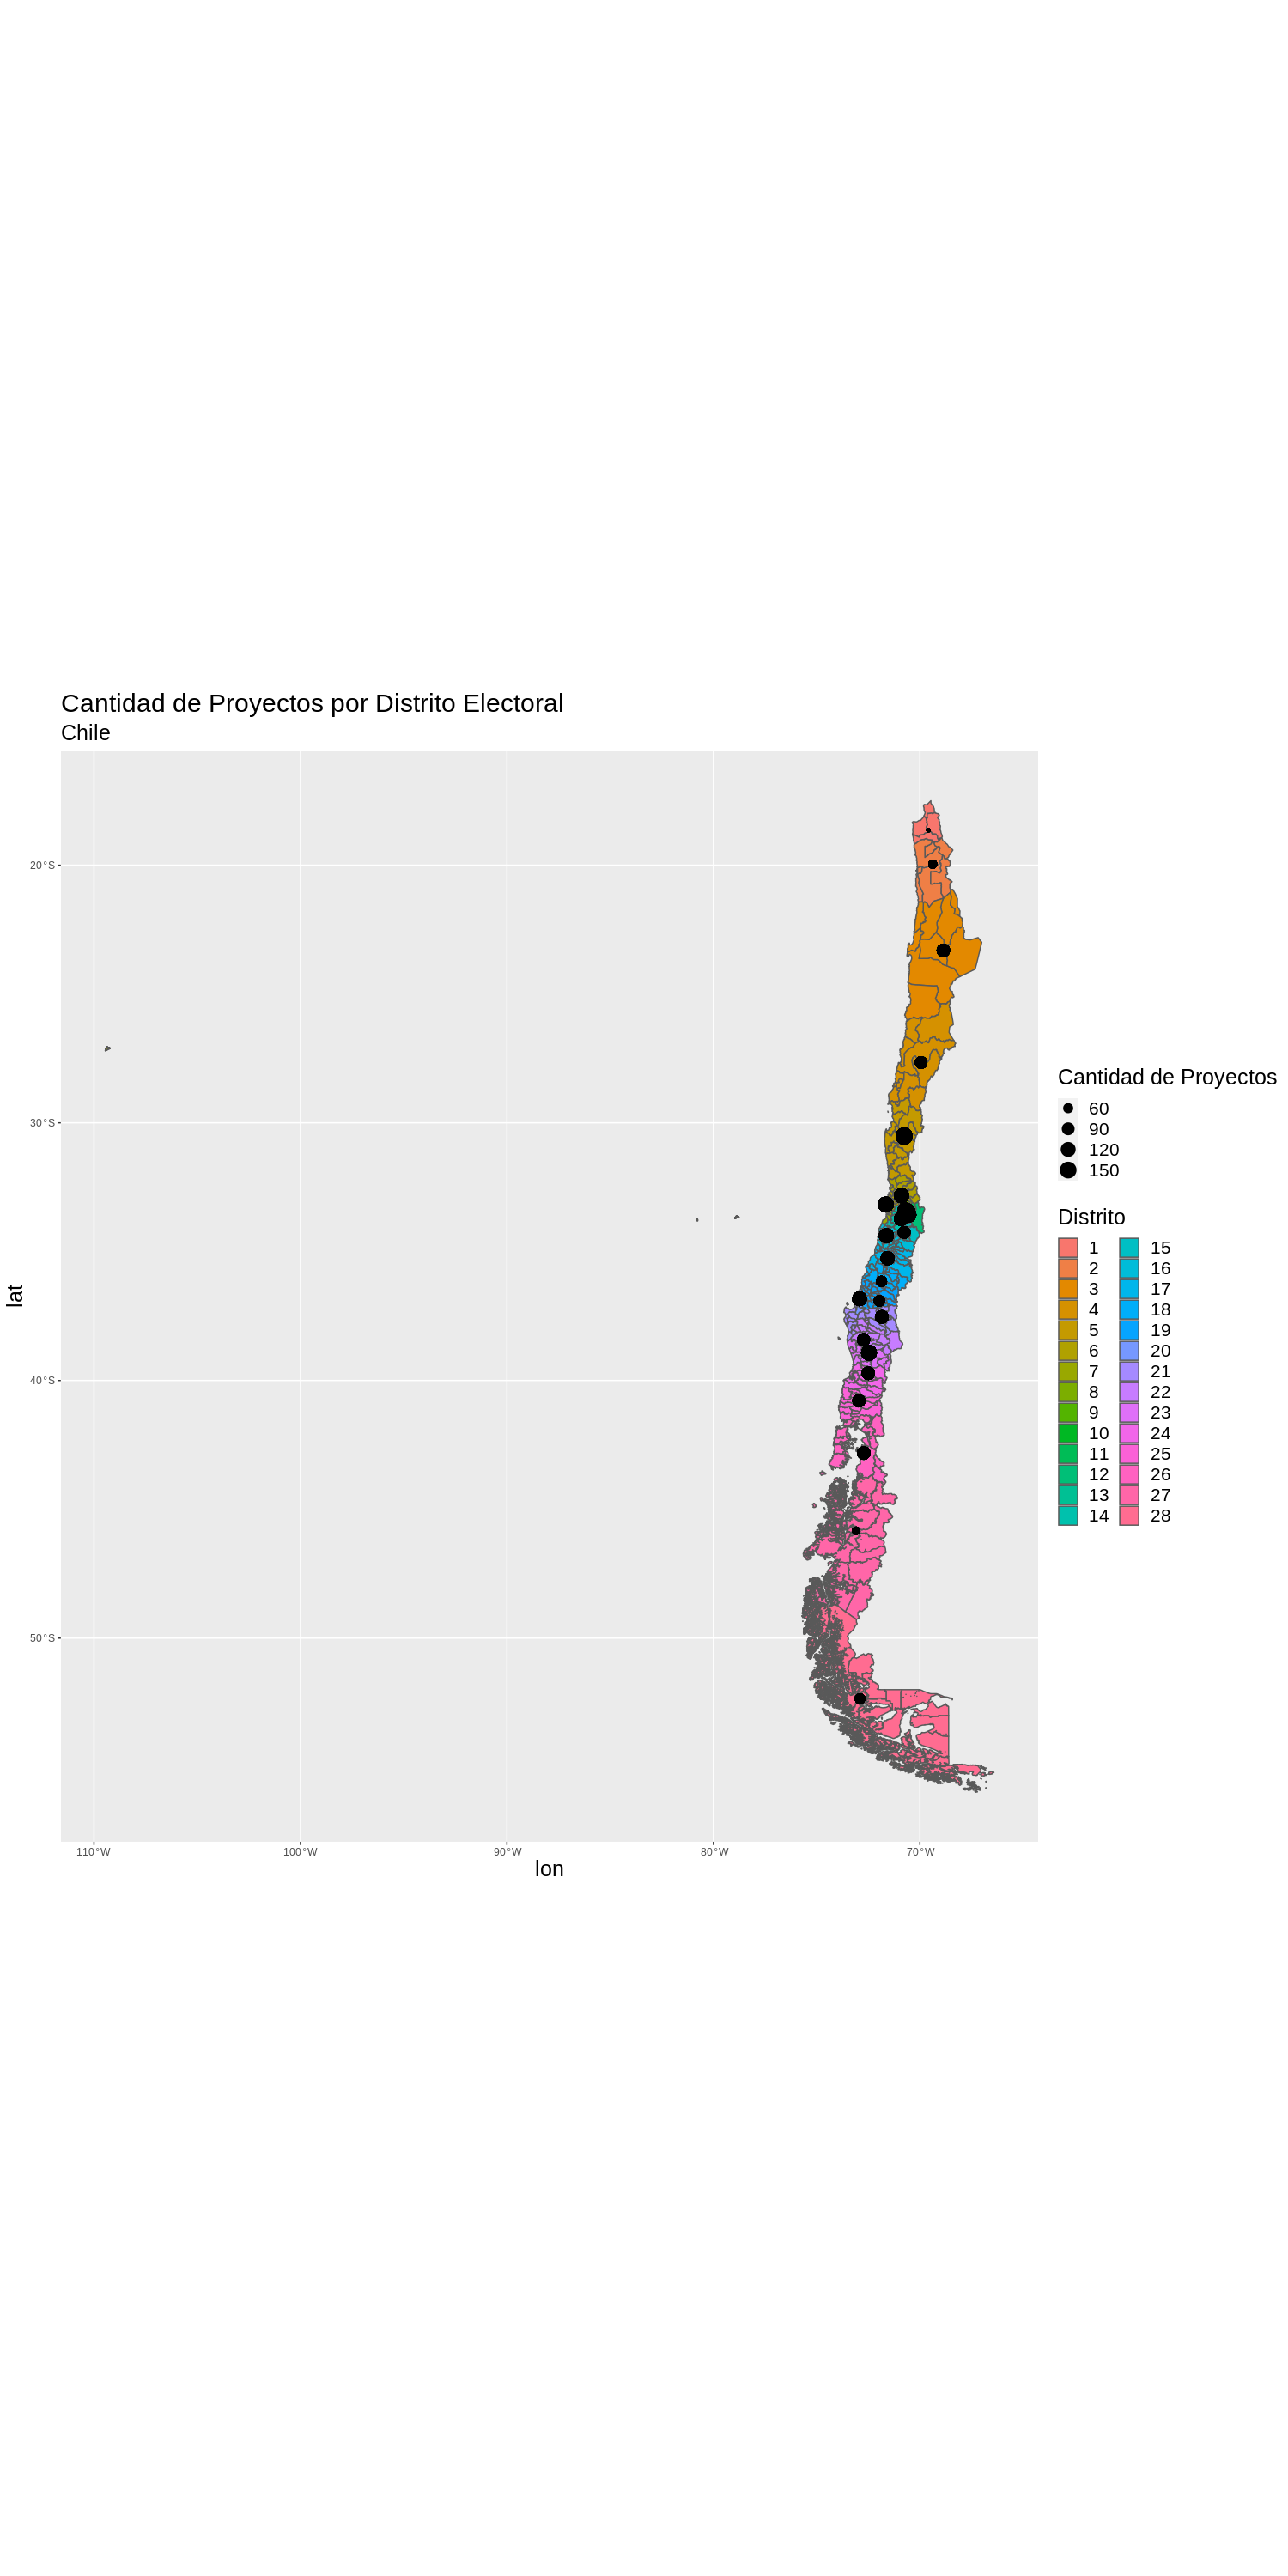

In [95]:
options(repr.plot.width = 15, repr.plot.height = 30, repr.plot.res = 100, warn=-1)
g_chile <- ggplot(comunas_sf %>% filter(DIS_ELEC != 0)) +
geom_sf(aes(fill=as.factor(nuevo_distrito))) + 
geom_point(data = leyes_autores_distritos %>% filter(!is.na(nuevo_distrito)), aes(x=lon,y=lat,size=proy_distrito)) +
scale_fill_discrete(name="Distrito") +
scale_size_continuous(name="Cantidad de Proyectos") +
labs(title="Cantidad de Proyectos por Distrito Electoral",subtitle="Chile") +
theme(legend.title = element_text(size=18),
legend.text = element_text(size=15),
title = element_text(size=18)) 
g_chile

In [96]:
num_proy_dist %>% arrange(nuevo_distrito)

nuevo_distrito,proy_distrito
<dbl>,<int>
1,35
2,51
3,95
4,85
5,154
6,121
7,131
8,97
9,140


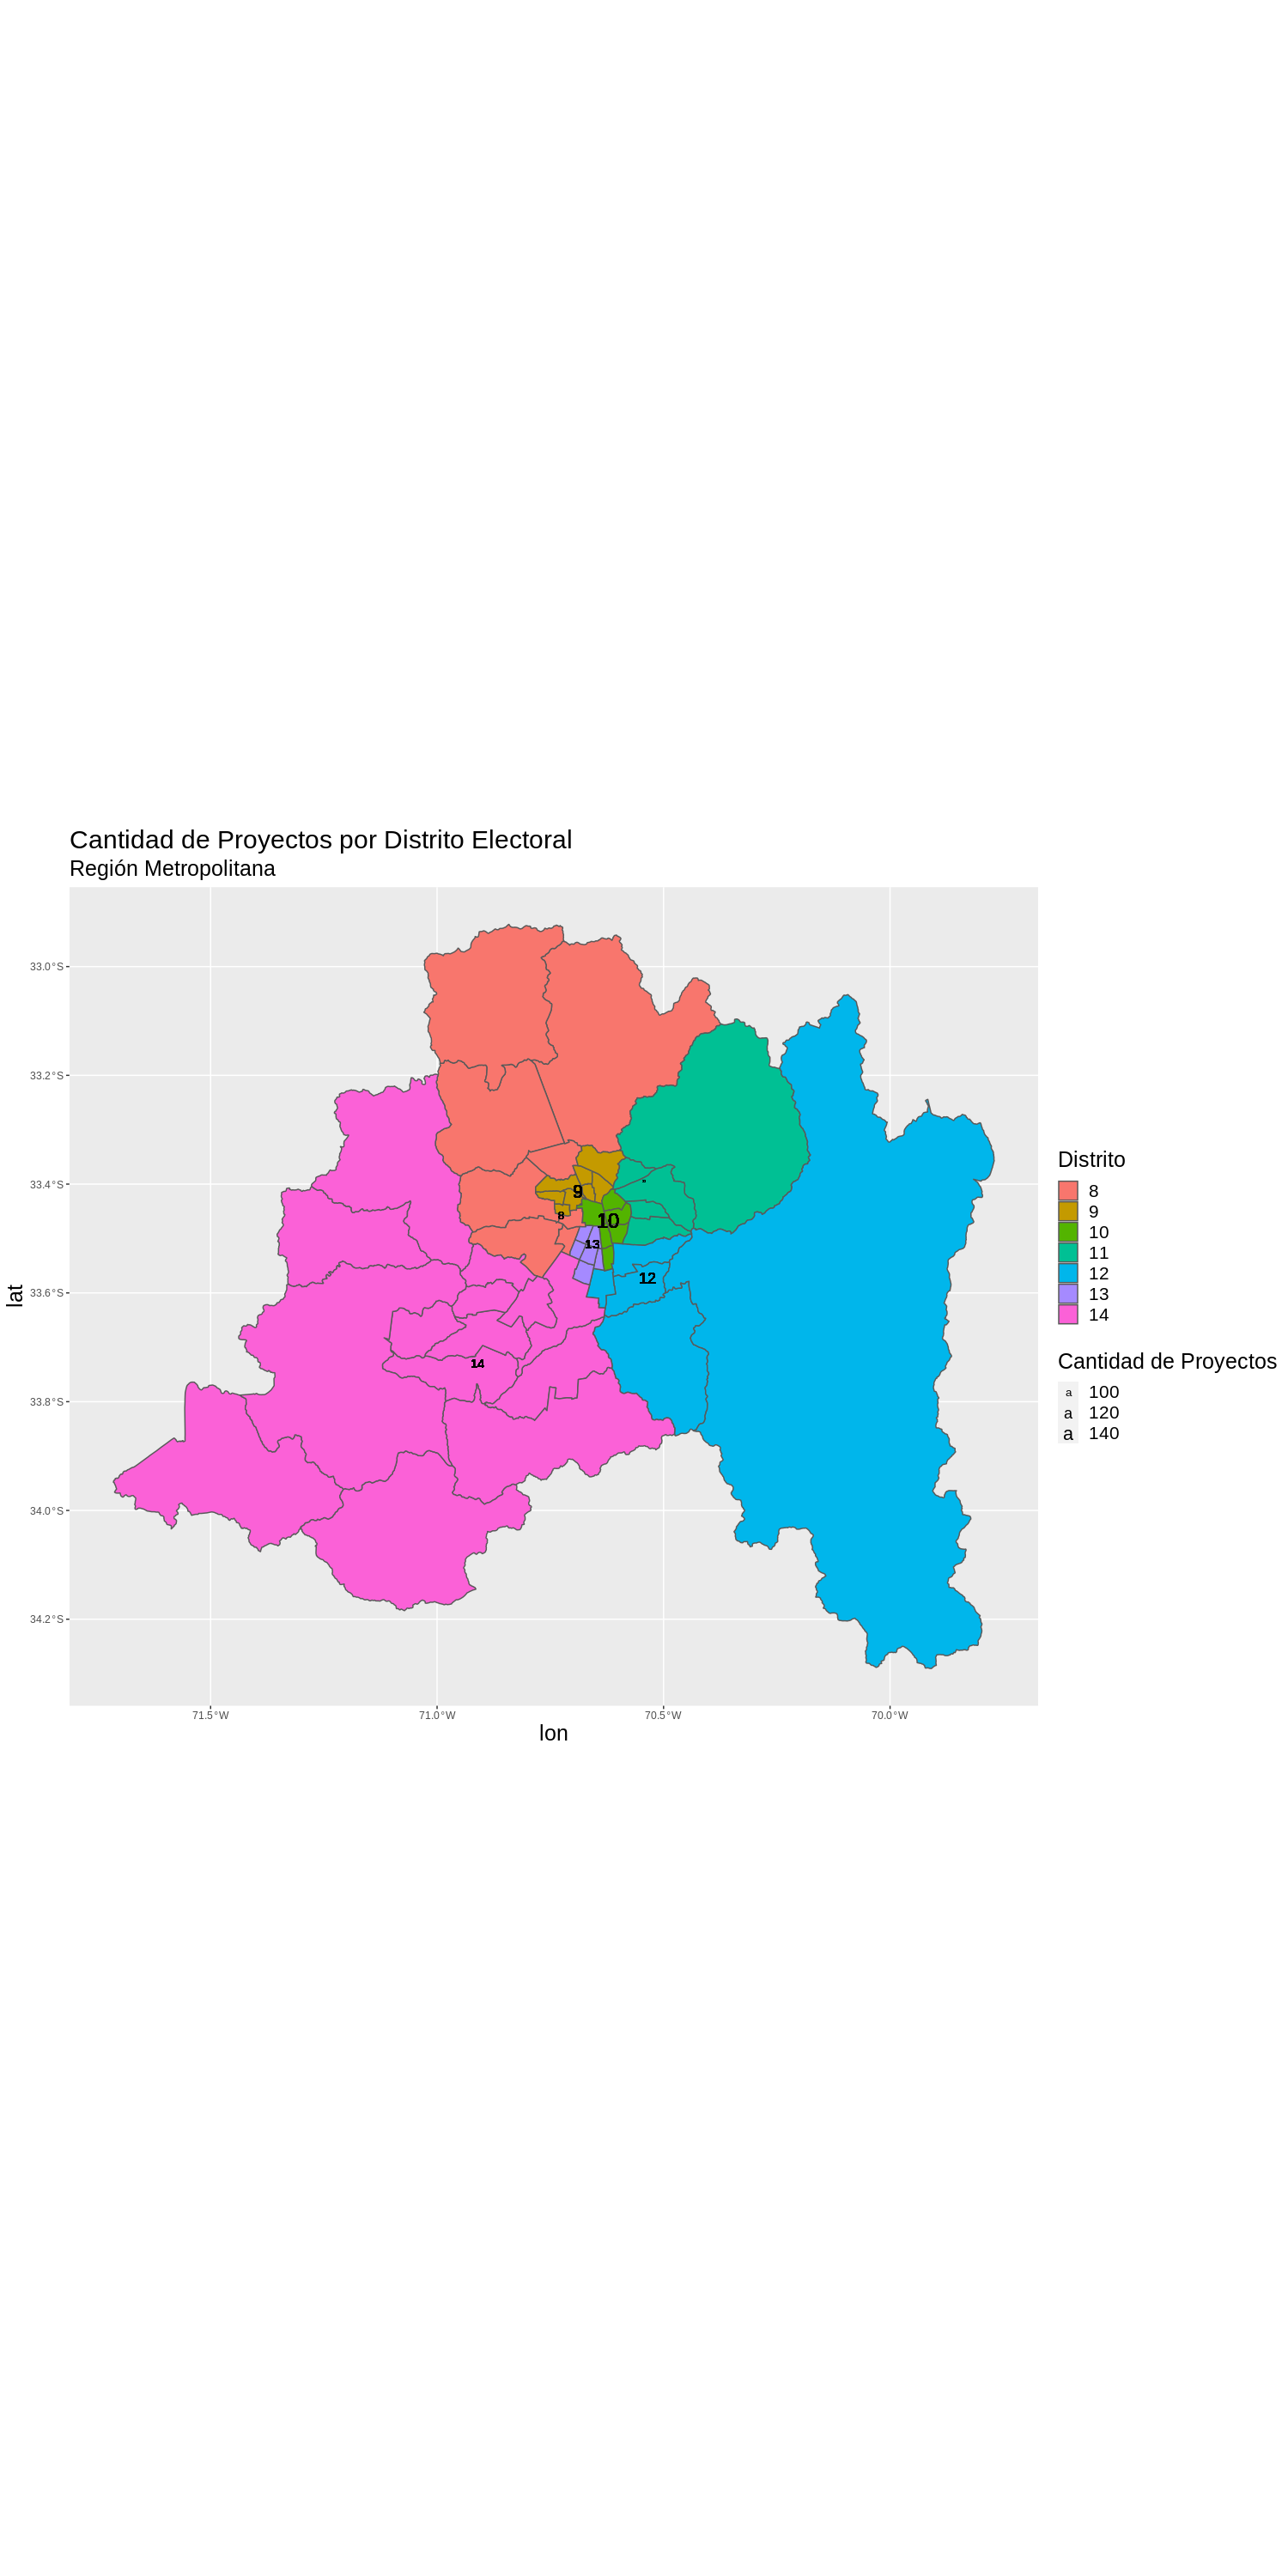

In [97]:
ggplot(comunas_sf %>% filter(NOM_REG == 'Región Metropolitana de Santiago')) +
geom_sf(aes(fill=as.factor(nuevo_distrito))) + 
geom_text(data = leyes_autores_distritos %>% filter(nuevo_distrito %in% seq(8,14)),aes(x=lon,y=lat,label=nuevo_distrito,size=proy_distrito)) +
scale_size_continuous(name="Cantidad de Proyectos") +
labs(title="Cantidad de Proyectos por Distrito Electoral",subtitle="Región Metropolitana",fill="Distrito") +
theme(legend.title = element_text(size=18),
legend.text = element_text(size=15),
title = element_text(size=18)) 

In [98]:
num_proy_dist %>% filter(nuevo_distrito %in% seq(8,14)) %>% arrange(desc(proy_distrito))

nuevo_distrito,proy_distrito
<dbl>,<int>
10,154
9,140
12,119
13,108
14,105
8,97
11,84


Al gráficar la cantidad de leyes promulgadas por distrito electoral se puede observar que la cantidad va aumentando a medida que se acerca al centro del país (Región Metropolitana). Lo anterior, evidencia una tendencia a la centralización en cuanto a las políticas emanadas a lo largo del período de estudio.

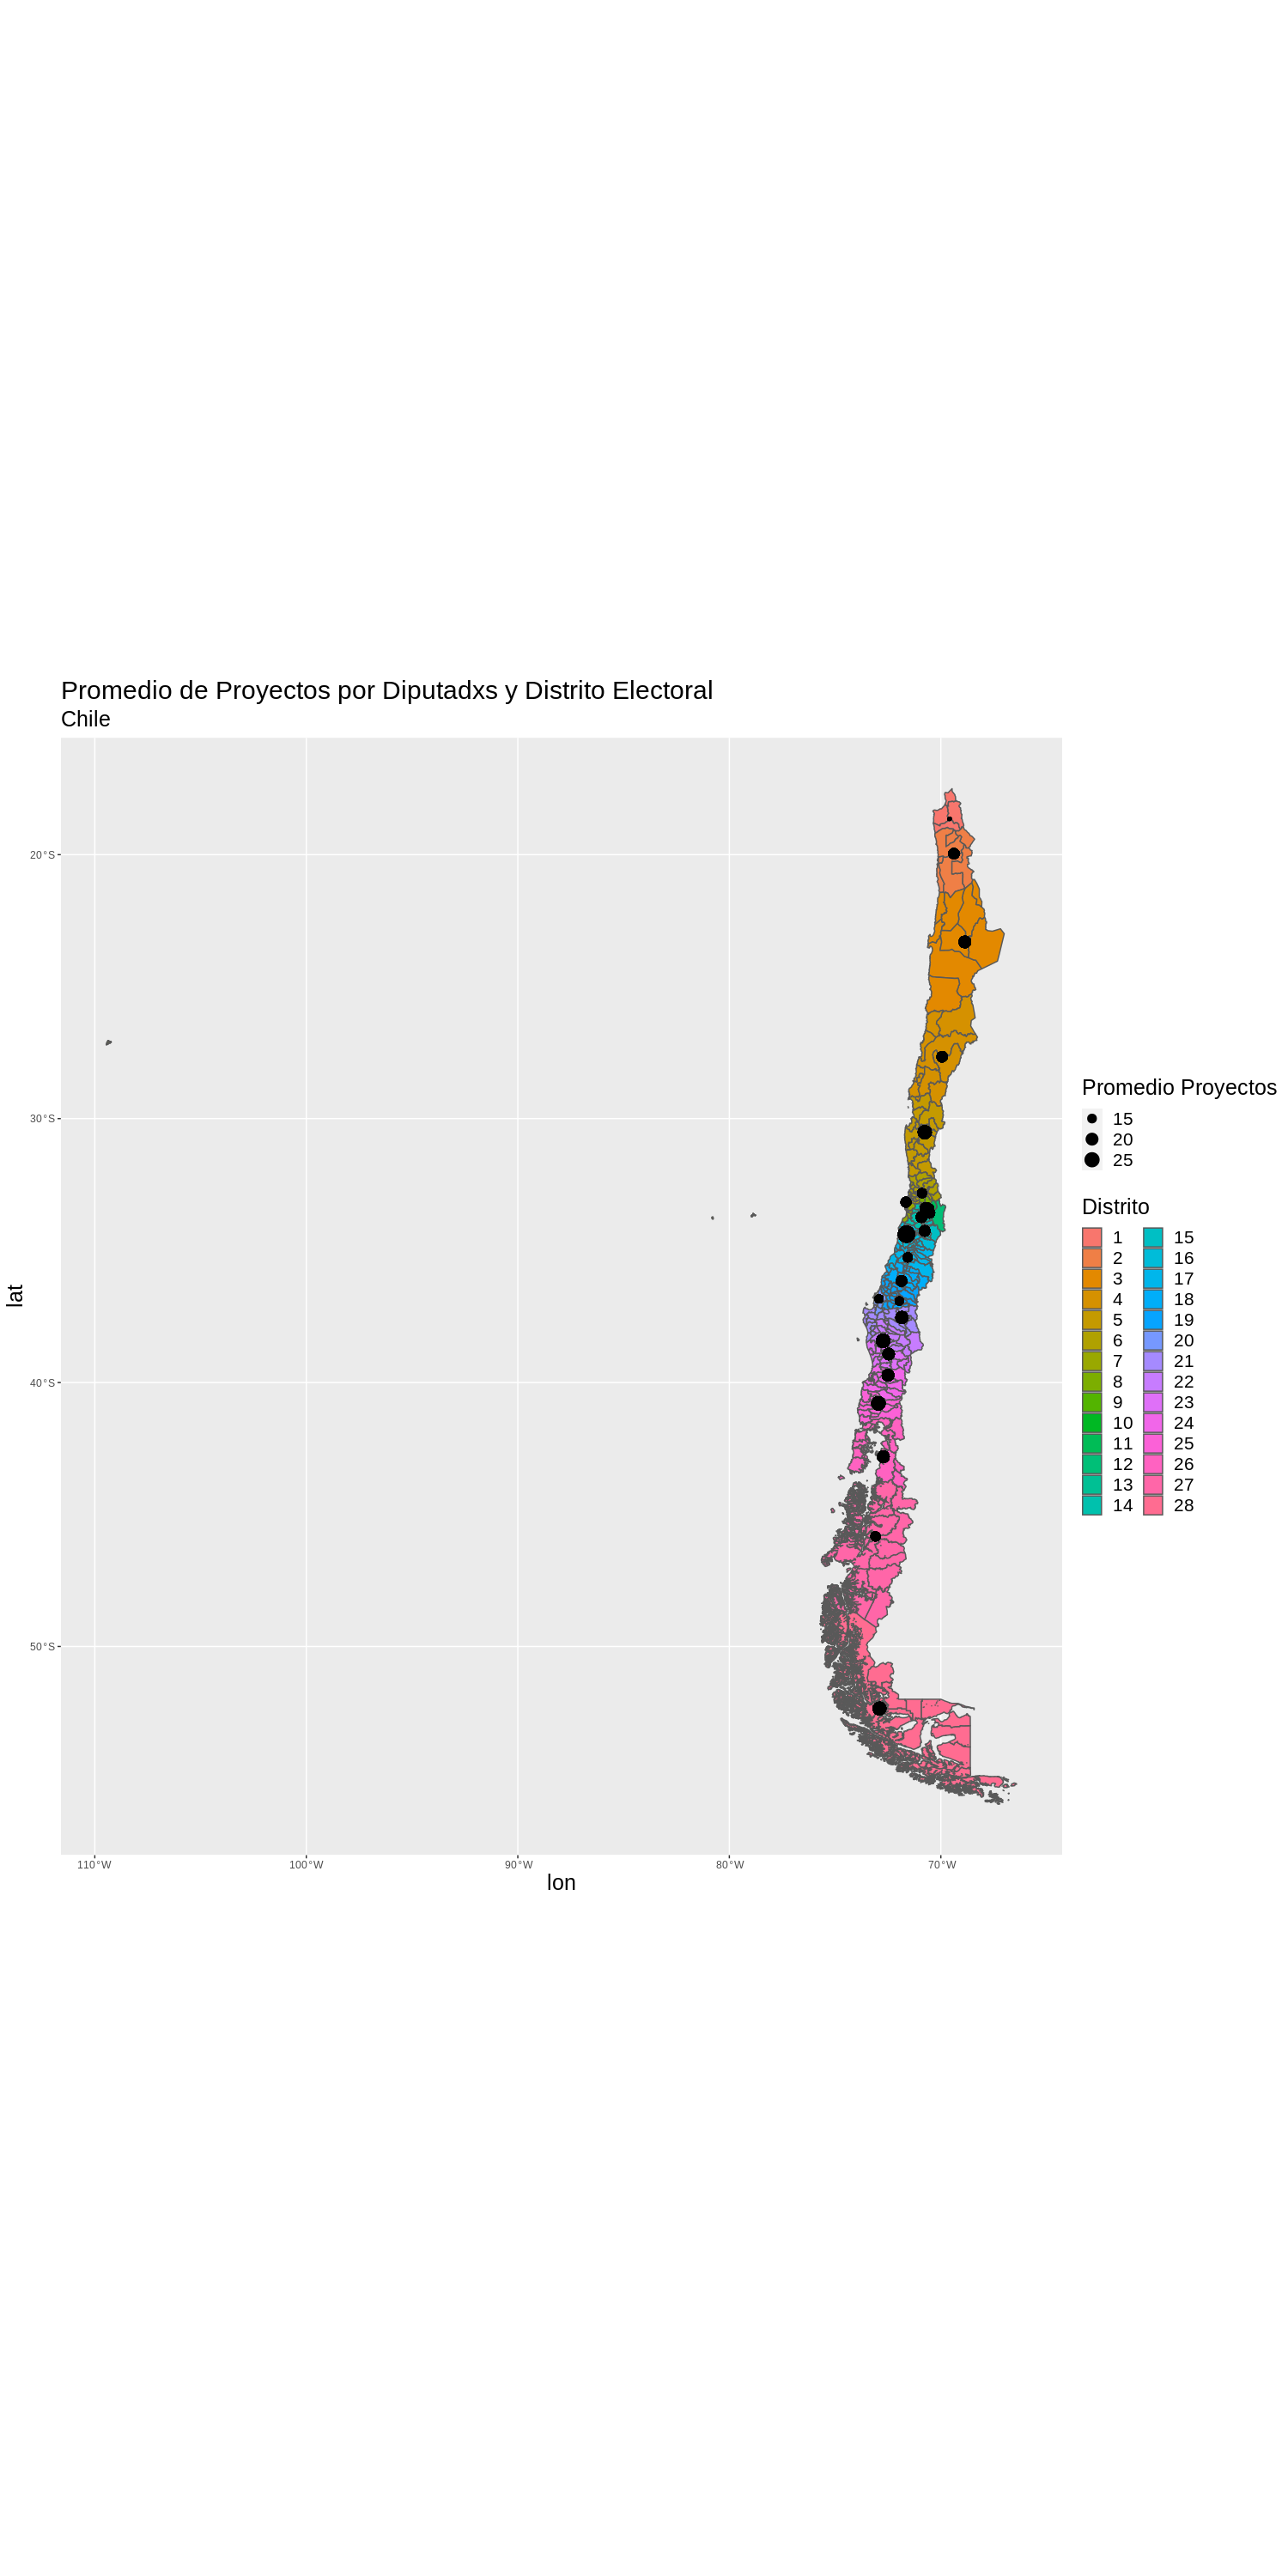

In [99]:
options(repr.plot.width = 15, repr.plot.height = 30, repr.plot.res = 100, warn=-1)
g_chile <- ggplot(comunas_sf %>% filter(DIS_ELEC != 0)) +
geom_sf(aes(fill=as.factor(nuevo_distrito))) + 
geom_point(data = leyes_autores_distritos %>% filter(!is.na(nuevo_distrito)), aes(x=lon,y=lat,size=proy_distrito/dipu_nuevo_distrito)) +
scale_fill_discrete(name="Distrito") +
scale_size_continuous(name="Promedio Proyectos") +
labs(title="Promedio de Proyectos por Diputadxs y Distrito Electoral",subtitle="Chile") +
theme(legend.title = element_text(size=18),
legend.text = element_text(size=15),
title = element_text(size=18)) 
g_chile

In [100]:
leyes_autores_distritos %>% 
select(nuevo_distrito, proy_distrito, dipu_nuevo_distrito) %>% 
mutate(proy_dipu=round(proy_distrito/dipu_nuevo_distrito,2)) %>% 
distinct() %>% 
arrange(desc(proy_dipu))

nuevo_distrito,proy_distrito,dipu_nuevo_distrito,proy_dipu
<dbl>,<int>,<dbl>,<dbl>
16,118,4,29.50
22,91,4,22.75
25,90,4,22.50
5,154,7,22.00
13,108,5,21.60
28,64,3,21.33
9,140,7,20.00
21,99,5,19.80
10,154,8,19.25


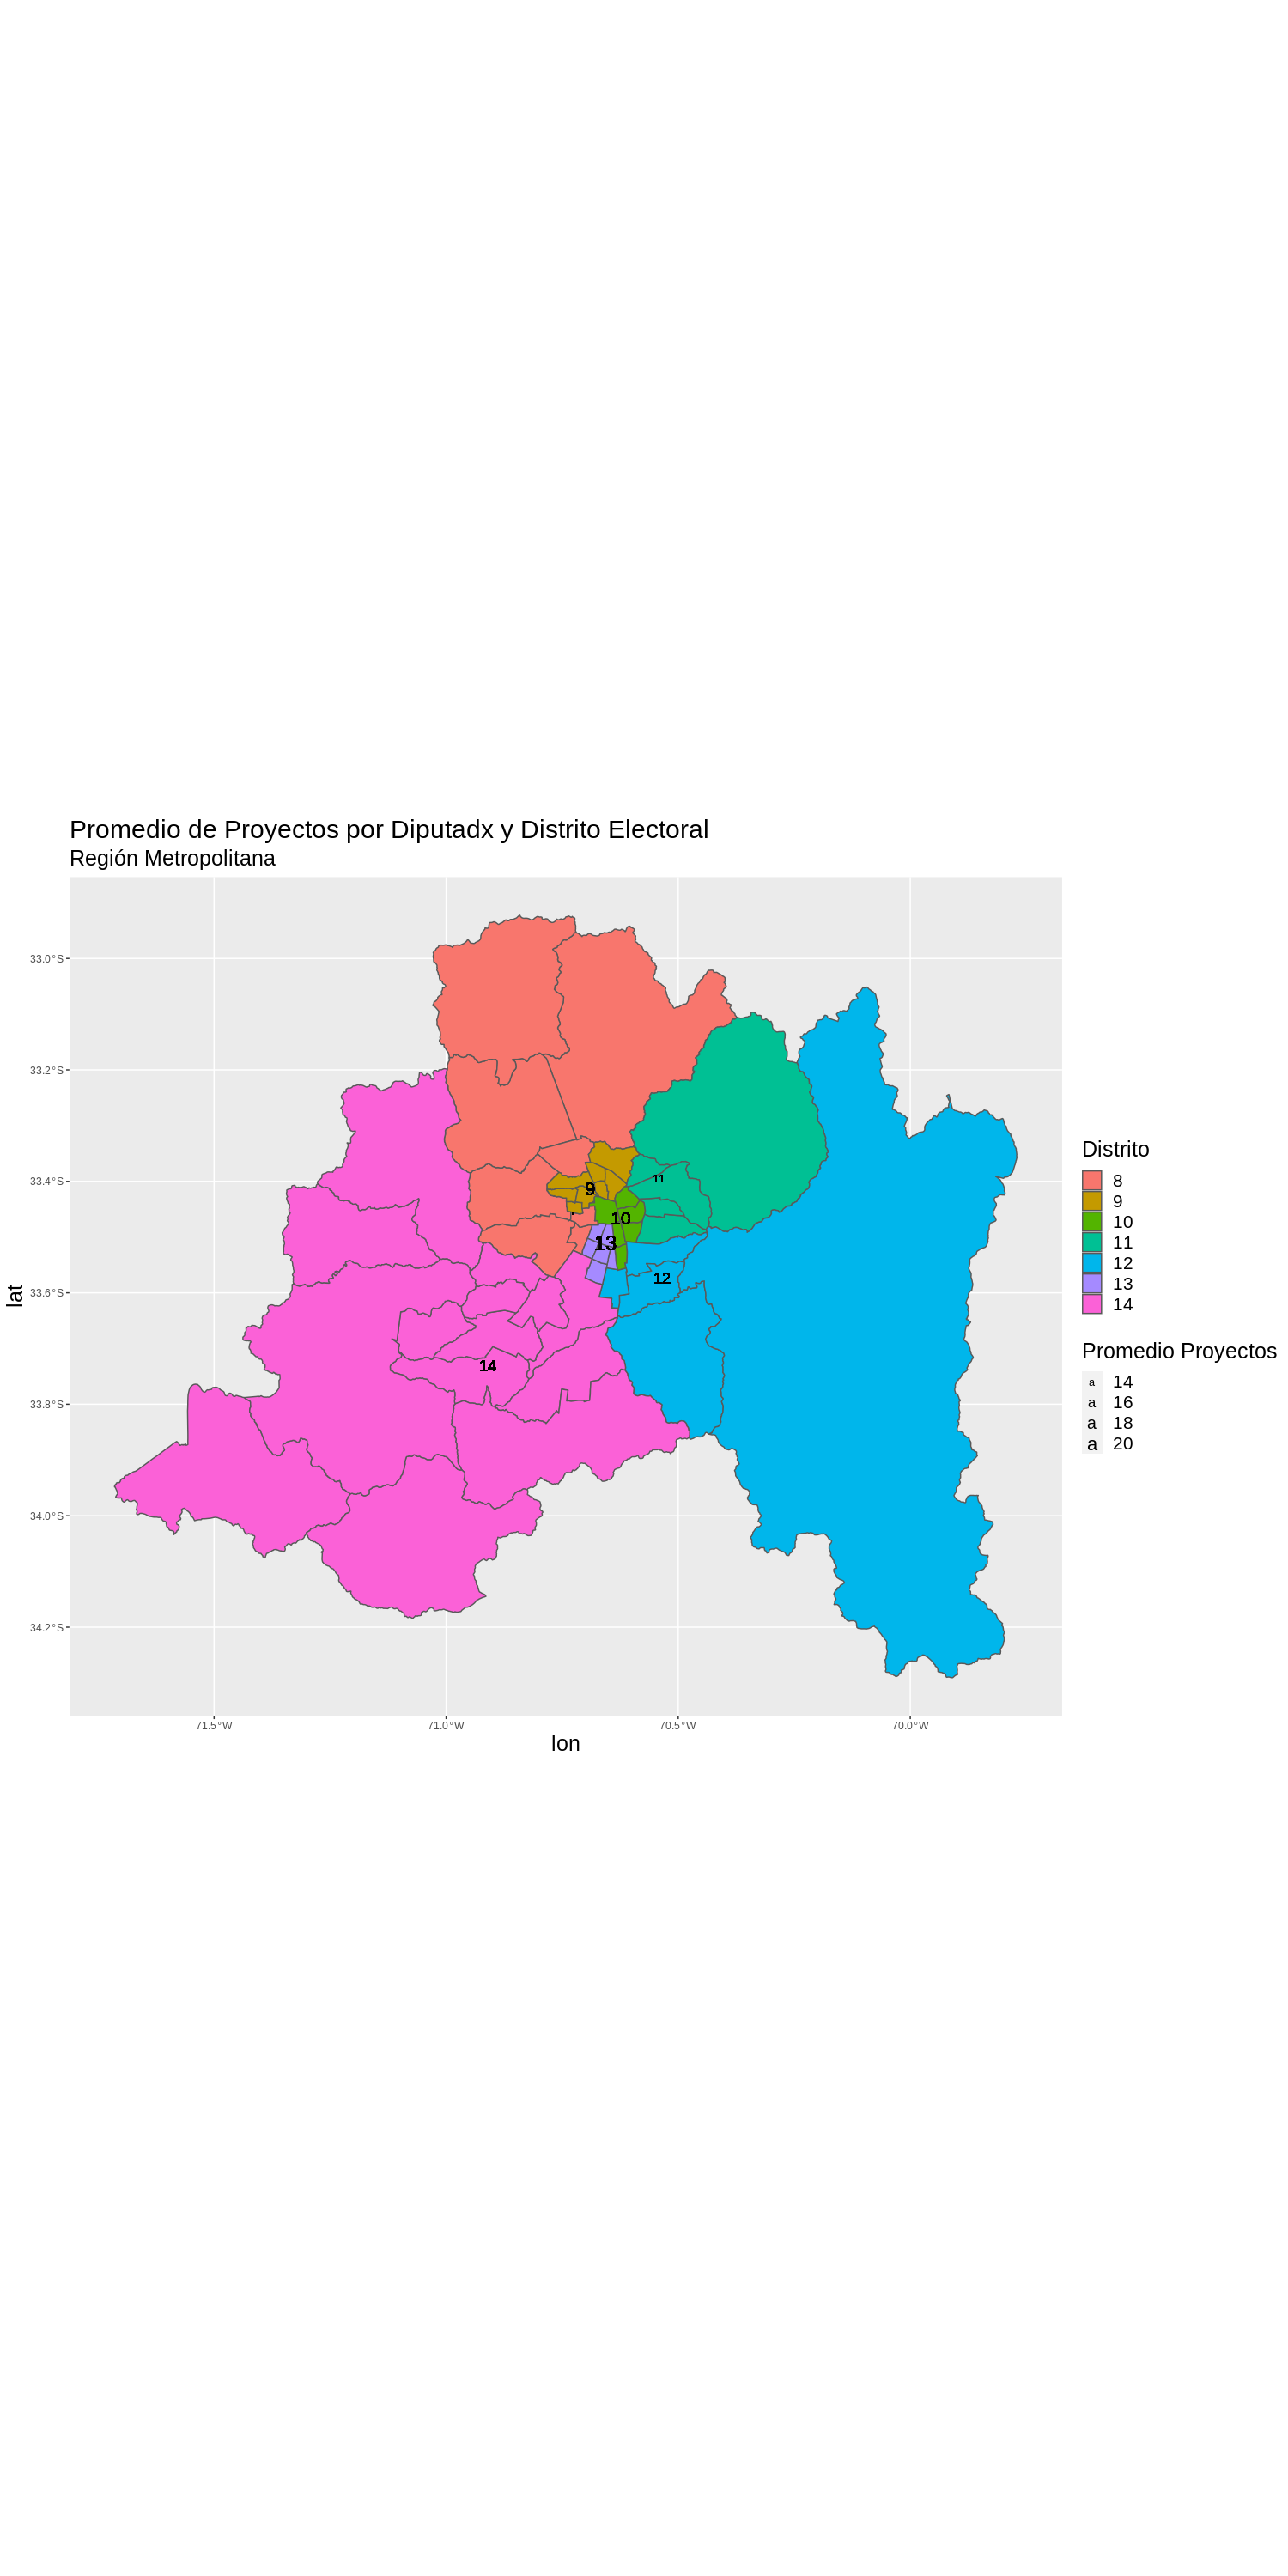

In [101]:
ggplot(comunas_sf %>% filter(NOM_REG == 'Región Metropolitana de Santiago')) +
geom_sf(aes(fill=as.factor(nuevo_distrito))) + 
geom_text(data = leyes_autores_distritos %>% filter(nuevo_distrito %in% seq(8,14)),aes(x=lon,y=lat,label=nuevo_distrito,size=proy_distrito/dipu_nuevo_distrito)) +
scale_size_continuous(name="Promedio Proyectos") +
labs(title="Promedio de Proyectos por Diputadx y Distrito Electoral",subtitle="Región Metropolitana",fill="Distrito") +
theme(legend.title = element_text(size=18),
legend.text = element_text(size=15),
title = element_text(size=18)) 

In [102]:
leyes_autores_distritos %>% 
select(nuevo_distrito, proy_distrito, dipu_nuevo_distrito) %>% 
filter(nuevo_distrito %in% seq(8,14)) %>% 
mutate(proy_dipu=round(proy_distrito/dipu_nuevo_distrito,2)) %>% 
distinct() %>% 
arrange(desc(proy_dipu))

nuevo_distrito,proy_distrito,dipu_nuevo_distrito,proy_dipu
<dbl>,<int>,<dbl>,<dbl>
13,108,5,21.60
9,140,7,20.00
10,154,8,19.25
14,105,6,17.50
12,119,7,17.00
11,84,6,14.00
8,97,8,12.12


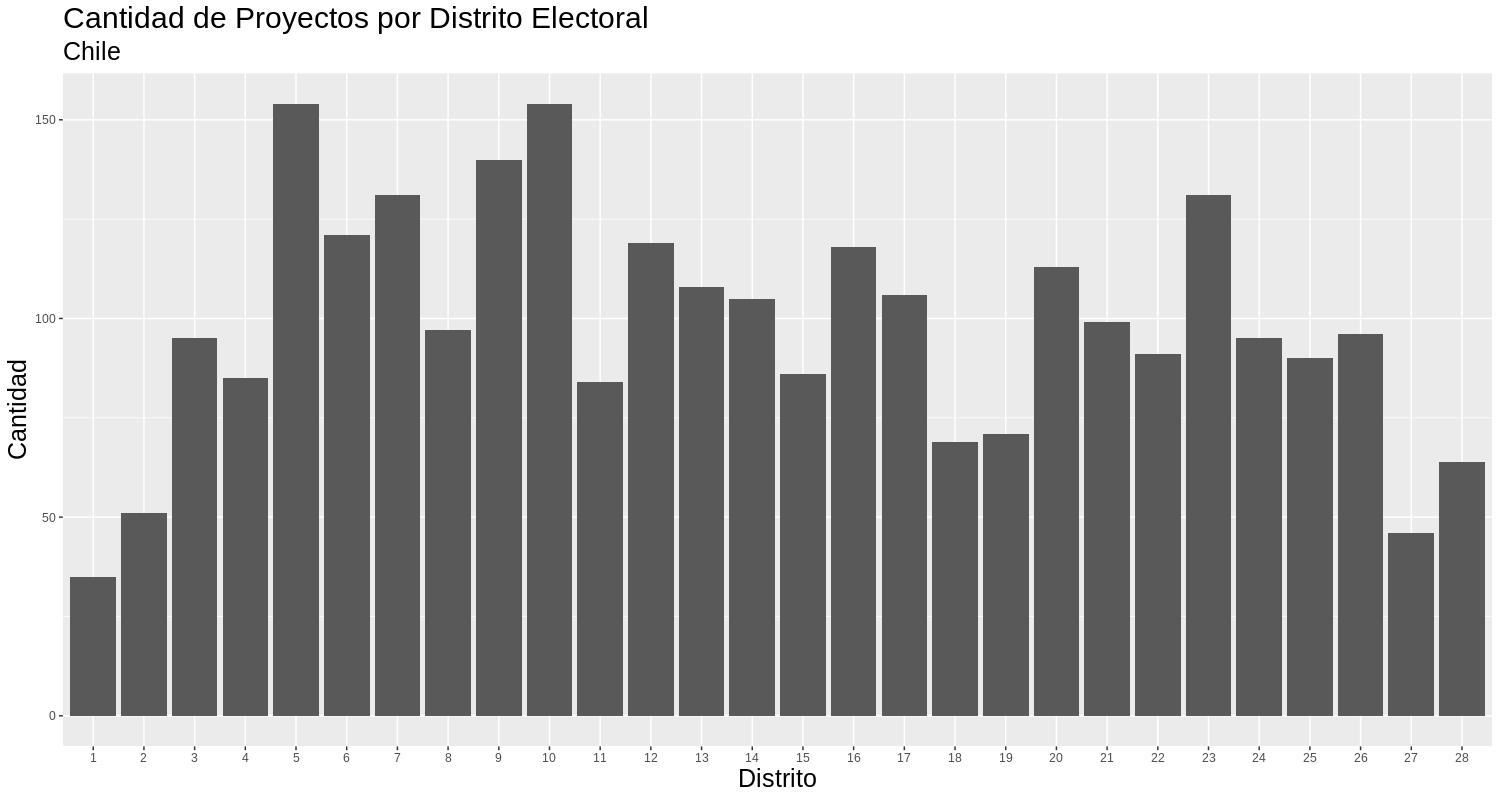

In [103]:
options(repr.plot.width = 15, repr.plot.height = 8, repr.plot.res = 100, warn=-1)
ggplot(num_proy_dist) +
geom_col(aes(x=as.factor(nuevo_distrito),y=proy_distrito,))+
labs(title="Cantidad de Proyectos por Distrito Electoral",subtitle="Chile",x="Distrito",y="Cantidad") +
theme(title = element_text(size=18)) 

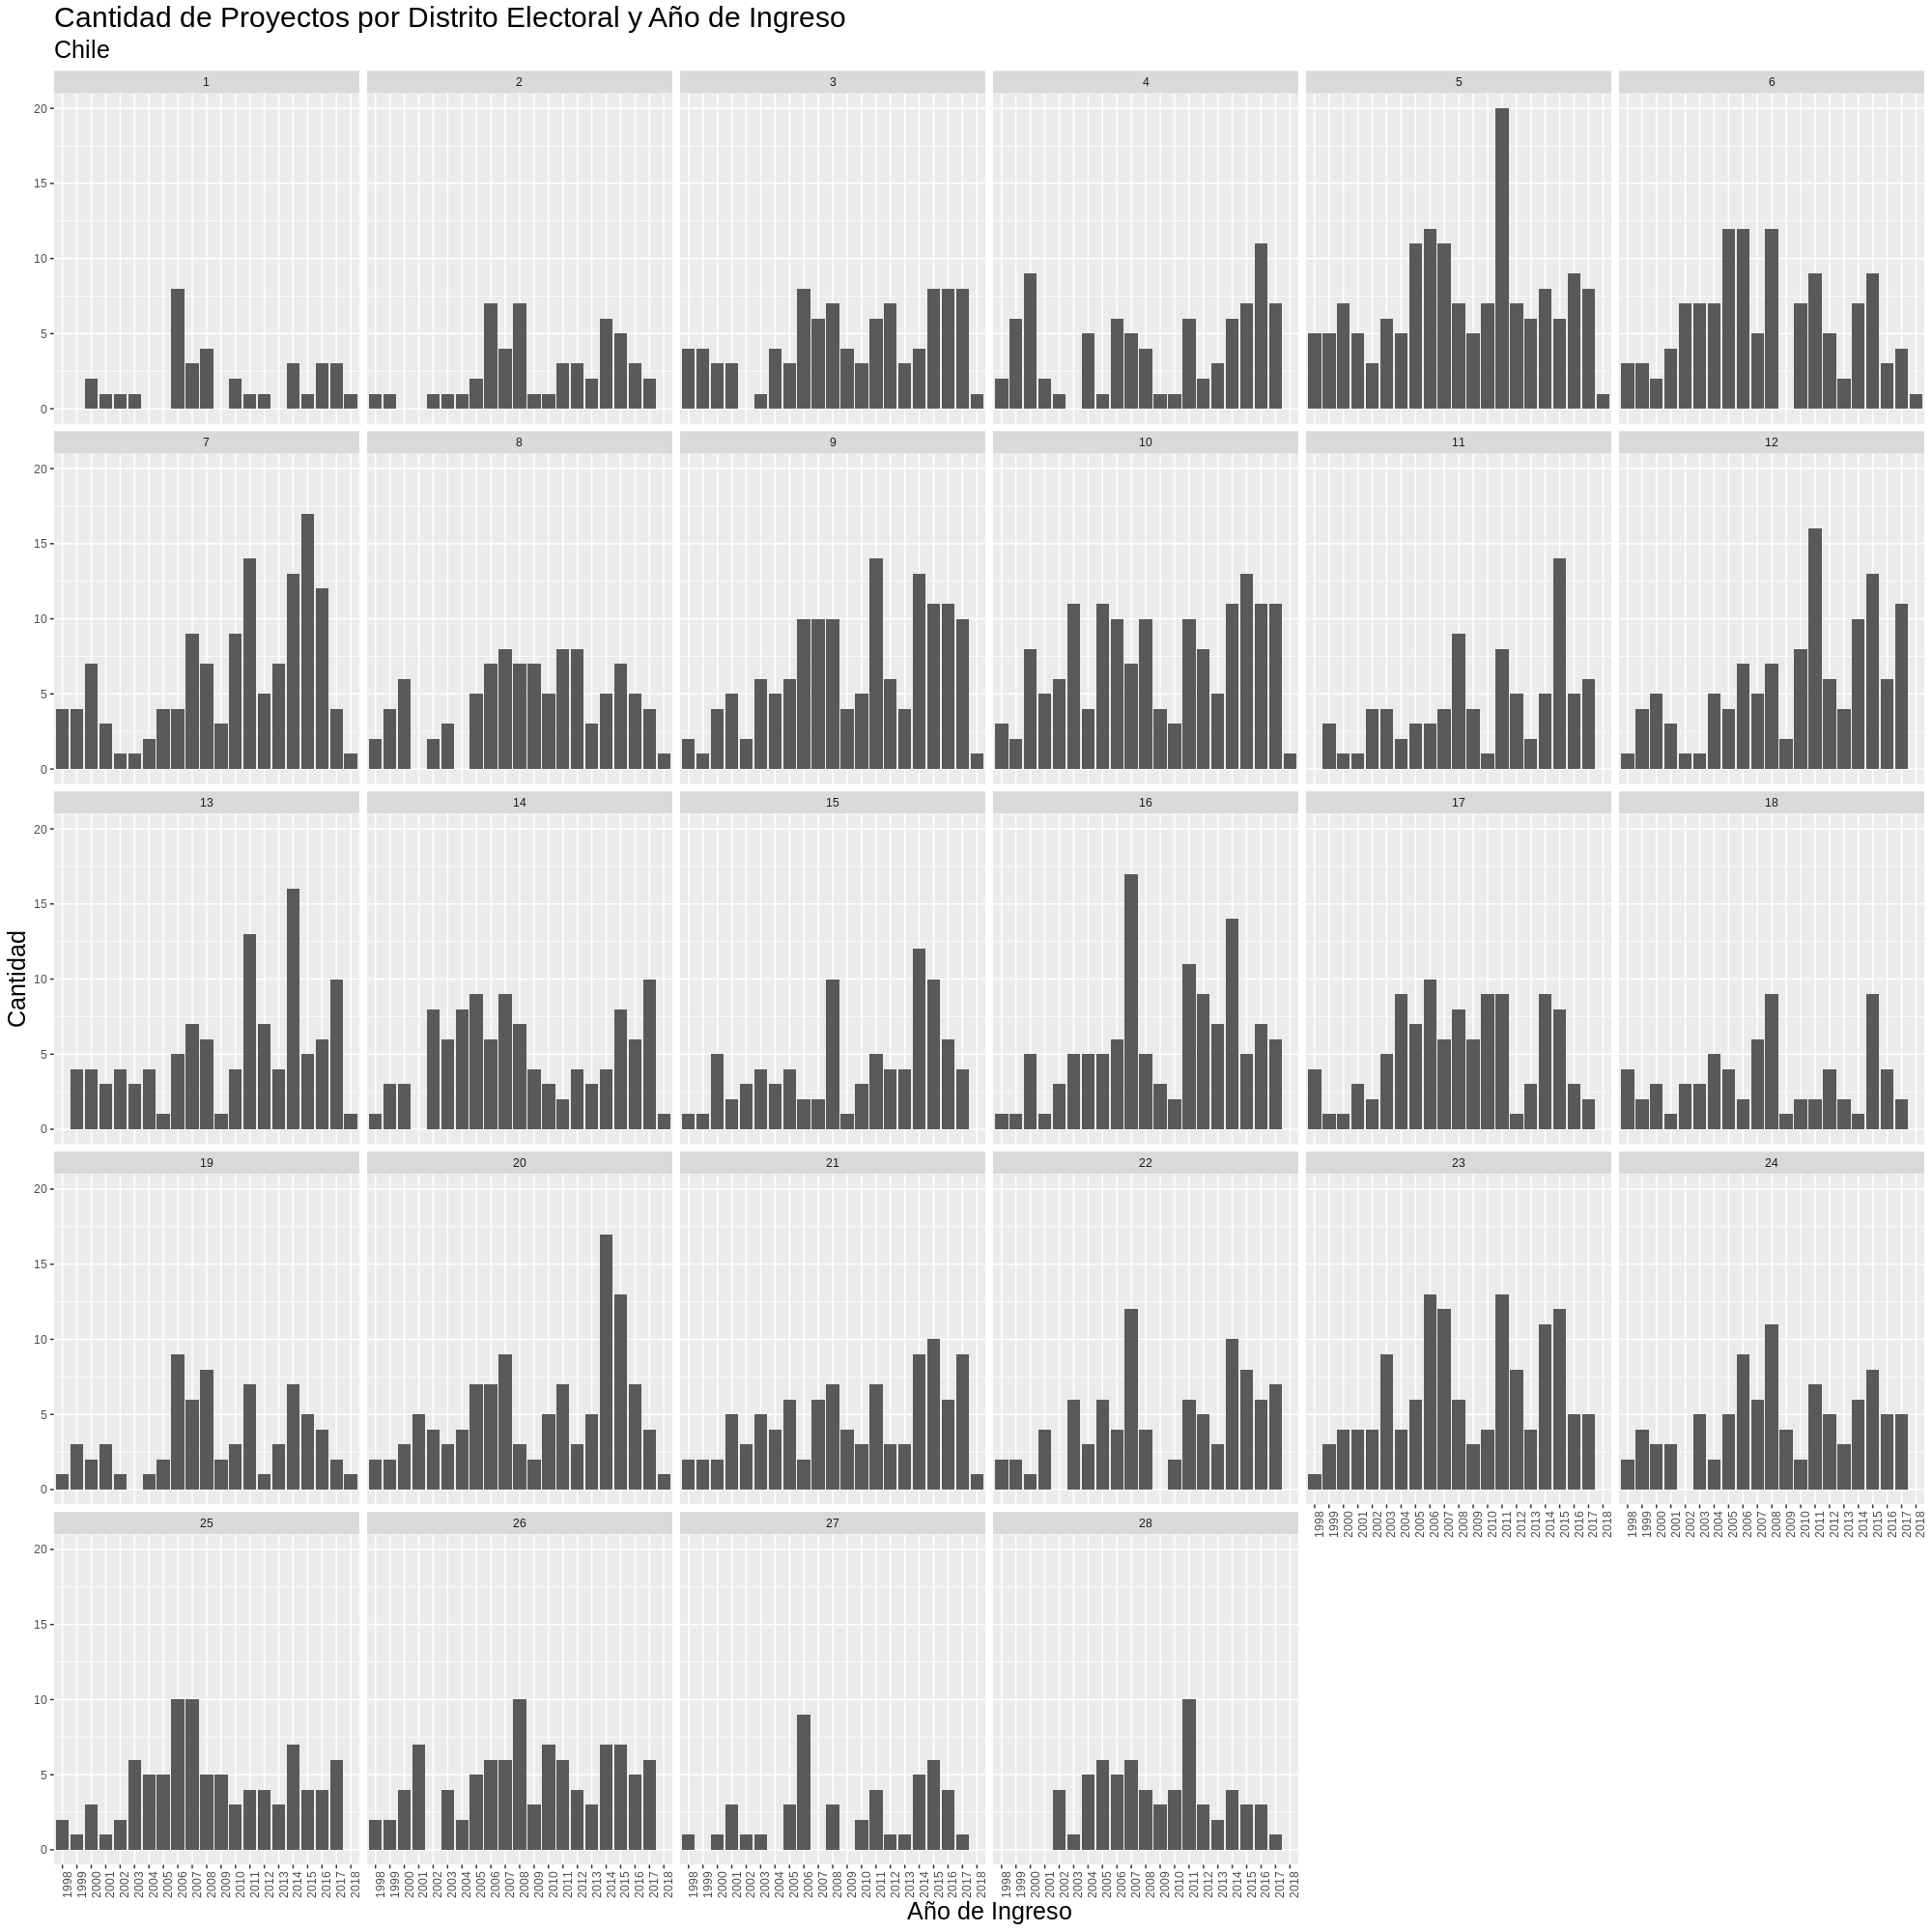

In [104]:
options(repr.plot.width = 20, repr.plot.height = 20, repr.plot.res = 100, warn=-1)
ggplot(num_proy_dist_anio) +
geom_col(aes(x=as.factor(anio_ingreso),y=proy_distrito_anio,group=nuevo_distrito))+
facet_wrap(vars(as.factor(nuevo_distrito)))+
labs(title="Cantidad de Proyectos por Distrito Electoral y Año de Ingreso",subtitle="Chile",x="Año de Ingreso",y="Cantidad") +
theme(title = element_text(size=18),
axis.text.x=element_text(angle=90)) 